# The Star System

The goal of the present project is to evaluate the impact of actors on movie ratings. Specifically, this could lead to distilling actors careers to a single number, a metric. Identifying the latter implies the need to identify truly successful actors, namely actors that had the highest positive impact on movies, in terms of ratings. Given the presence of multiple confounders, such as the affinity of actors with particulare genres, gender disparities or the preference of directors for specific actors, an observational study is carried out to limit the influence of unobserved covariates.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
%matplotlib inline

import datetime as dt
import networkx as nx
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.weightstats import ztest
from networkx.algorithms import bipartite
import re
import warnings
warnings.filterwarnings('ignore')

# Data Cleaning and Pre-Processing

Import all the data

Note: you need to download these files from the imdb dataset website:

title.basics.tsv.gz

title.ratings.tsv.gz

names.basics.tsv.gz

title.principals.tsv.gz

title.crew.tsv.gz

In [439]:
#import imdb datasets

#contains movie titles
titles_imdb = pd.read_csv('../data/title.basics.tsv.gz', sep='\t', compression='gzip')

#contains movie ratings
ratings_imdb = pd.read_csv('../data/title.ratings.tsv.gz', sep='\t', compression='gzip')

#contains actors names
name_imdb = pd.read_csv('../data/name.basics.tsv.gz', sep='\t', compression='gzip')

#contains director names
crew_imdb = pd.read_csv('../data/title.crew.tsv.gz', sep='\t', compression='gzip')

#contains movie names
name_movies_imdb = pd.read_csv('../data/title.principals.tsv.gz', sep='\t', compression='gzip')

**Name, Movie and Actor/Actress Dataset**: limit the dataset to only actor/actresses, their name ids and movie ids

In [440]:
#keep only actors and actresses
actor = name_movies_imdb.loc[name_movies_imdb['category'] == 'actor']
actress = name_movies_imdb.loc[name_movies_imdb['category'] == 'actress']
actor_actress = pd.concat([actor, actress])

In [442]:
#keep only useful features
actor_actress = actor_actress[['tconst', 'nconst', 'category']]
actor_actress.head(3)

tconst     nconst category
11  tt0000005  nm0443482    actor
12  tt0000005  nm0653042    actor
16  tt0000007  nm0179163    actor

Merge with dataset containing the names of the actors/actresses

In [443]:
#merge
actor_actress_names = actor_actress.merge(name_imdb, 'inner', on='nconst')

In [444]:
#limit to important features and rename name column
actor_actress_names = actor_actress_names[['tconst', 'category', 'primaryName']].rename(columns={'primaryName': 'ActorName'})

In [449]:
actor_actress_names.head(3)

tconst category         ActorName
0  tt0000005    actor    Charles Kayser
1  tt0000005    actor          John Ott
2  tt0000007    actor  James J. Corbett

Merge crew dataset containing director name ids with name dataset

In [445]:
#merge
directors = name_imdb.merge(crew_imdb, 'inner', left_on='nconst', right_on='directors')

In [446]:
#limit to important features and rename name column
directors = directors[['primaryName', 'tconst']].rename(columns={'primaryName': 'Director'})

In [450]:
directors.head(3)

Director     tconst
0  Ingmar Bergman  tt0038468
1  Ingmar Bergman  tt0038675
2  Ingmar Bergman  tt0039834

Merge ratings dataset with movie title dataset

In [447]:
#merge
ratings_titles = titles_imdb.merge(ratings_imdb, how='inner')

In [448]:
#remove unnecessary features and limit the titles dataset to only movies
movie_rating = ratings_titles.loc[ratings_titles['titleType'] == 'movie'][['tconst', 'primaryTitle', 'startYear', 'genres', 'averageRating', 'numVotes']]

In [451]:
movie_rating.head(3)

tconst                   primaryTitle startYear  \
8    tt0000009                     Miss Jerry      1894   
144  tt0000147  The Corbett-Fitzsimmons Fight      1897   
325  tt0000502                       Bohemios      1905   

                     genres  averageRating  numVotes  
8                   Romance            5.3       200  
144  Documentary,News,Sport            5.2       460  
325                      \N            4.2        14

Merge the three datasets we created above to obtain a dataset containing all the needed movie features.

In [452]:
# Director merge
merge1 = movie_rating.merge(directors, 'inner', on='tconst')

In [453]:
# above merge with actor names
data = merge1.merge(actor_actress_names, 'inner', on='tconst')

In [454]:
# replace /N with nan
data_nan = data.replace(r'\N', np.nan)

In [455]:
# drop nans (only useful features kept)
data_no_nan = data_nan.dropna(axis=0, how='any')

In [456]:
data_no_nan.head(3)

tconst primaryTitle startYear   genres  averageRating  numVotes  \
0  tt0000009   Miss Jerry      1894  Romance            5.3       200   
1  tt0000009   Miss Jerry      1894  Romance            5.3       200   
2  tt0000009   Miss Jerry      1894  Romance            5.3       200   

          Director category          ActorName  
0  Alexander Black    actor  William Courtenay  
1  Alexander Black    actor     Chauncey Depew  
2  Alexander Black  actress    Blanche Bayliss

In [502]:
#load datasets of regions and birthdates
imdb_regions = pd.read_csv('../data/title.akas.tsv.gz',compression='infer',sep='\t') #imdb dataset with regions
imdb_birth = pd.read_csv('../data/name.basics.tsv.gz',compression='infer',sep='\t') #imdb dataset with actors birthdates

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

Important:

Birthdates were initially considered in the observed covariates, and this is why we drop actors with missing birthdates. This should not have a strong impact on the study, given that we are dropping entire actors careers and not data points in the middle of the career of an actor.

However, we then found high correlation with appearances. Therefore, they cannot be considered as predictors for the logistic regression to extract the propensity scores.

In [354]:
#deal with the nan values of birth dates
imdb_birth = imdb_birth.replace(r'\N', np.nan) #replace
imdb_birth.dropna(subset=['birthYear'],inplace=True) #drop

In [356]:
imdb_g = data_no_nan.merge(imdb_regions, 'inner', left_on='tconst', right_on='titleId') #merge datasets
imdb_g.drop(['title'],axis=1,inplace=True) #remove duplicate columns

In [357]:
#merge to get starting dataset
imdb_y = imdb_birth.merge(imdb_g, 'inner', left_on='primaryName', right_on='ActorName')

In [358]:
#keep useful columns
imdb_y = imdb_y[{'birthYear','primaryTitle','startYear','genres','averageRating','numVotes','Director',
           'category','ActorName','region','types'}]

The study will be focused in the US movie industry.

In [359]:
#extract only US industry rows of the dataset
us = imdb_y[imdb_y['region'] == 'US']
print('We will start with ' + str(len(it)) + ' data points')

We will start with 497470 data points


In [360]:
#simplify columns names
us.rename(columns={'primaryTitle':'title','startYear':'year','ActorName':'actor','category':'gender'},inplace=True)

In [361]:
#simplify gender columns
us['gender'][it['gender'] == 'actor'] = 'M'
us['gender'][it['gender'] == 'actress'] = 'F'

In [362]:
#funtion to perform min-max scaling
def minMaxScale(data, imposed_minimum = None, imposed_maximum = None, fit = False): #min max scaling
    mini = min(data)
    maxi = max(data)
    
    if (imposed_minimum != None): mini = imposed_minimum
    if (imposed_maximum != None): maxi = imposed_maximum
    if (fit == False):
        return (data - mini)/(maxi - mini)
    else: 
        return [mini, maxi]

In [363]:
#normalize the ratings by the number of votes
us['numVotes_factor'] = minMaxScale(np.log(us['numVotes']), 0)
us['averageRating_adj'] =  us['averageRating']* us['numVotes_factor']

In [364]:
#make dataset more easy to use (simplify names replacing spaces with underscores)
us['actor'] = us["actor"].apply(lambda x : '_'.join(x.split())) #simplifying actor names
us['Director'] = us["Director"].apply(lambda x : '_'.join(x.split())) #simplifying director names

actorMetrics = pd.DataFrame(us['actor'].drop_duplicates().reset_index(drop = True)) #creation of starscore dataf

timeScores = pd.DataFrame(us['actor'].drop_duplicates().reset_index(drop = True))

In [365]:
len(us)

497470

In [369]:
us.head()

title           Director birthYear  year        types region  \
25   The Gay Divorcee      Mark_Sandrich      1899  1934  imdbDisplay     US   
41            Roberta  William_A._Seiter      1899  1935  imdbDisplay     US   
80            Top Hat      Mark_Sandrich      1899  1935      working     US   
90            Top Hat      Mark_Sandrich      1899  1935  imdbDisplay     US   
101  Follow the Fleet      Mark_Sandrich      1899  1936  imdbDisplay     US   

    gender  averageRating         actor                  genres  numVotes  \
25       M            7.4  Fred_Astaire  Comedy,Musical,Romance      8048   
41       M            7.0  Fred_Astaire  Comedy,Musical,Romance      3423   
80       M            7.7  Fred_Astaire  Comedy,Musical,Romance     19391   
90       M            7.7  Fred_Astaire  Comedy,Musical,Romance     19391   
101      M            7.1  Fred_Astaire  Comedy,Musical,Romance      4461   

     numVotes_factor  averageRating_adj  
25          0.607910           4.498532  
41          0.550121           3.850846  
80          0.667353           5.138620  
90          0.667353           5.138620  
101         0.568024           4.032972

In [370]:
#create a dataframe of actors

metrics_avg = {'averageRating_adj' : 'grade_avg'}
metrics_sum = {'averageRating_adj' : 'grade_sum'}

for idx, (key, value) in enumerate(metrics_avg.items()):
    print(idx)
    lists_per_actor = us.groupby('actor').apply(lambda x : np.mean(x[key])).reindex(
        index = actorMetrics['actor'].values)
    actorMetrics[value] = lists_per_actor.values
       
for idx, (key, value) in enumerate(metrics_sum.items()):
    print(idx)
    lists_per_actor = us.groupby('actor').apply(lambda x : sum(x[key])).reindex(
        index = actorMetrics['actor'].values)
    actorMetrics[value] = lists_per_actor.values
    
    
appearances_per_actor = us.groupby('actor')['title'].count().reindex(
    index = actorMetrics['actor'].values).reset_index(drop = True)
actorMetrics['appearances'] = appearances_per_actor

0
0


In [371]:
actors = actorMetrics
print('We are investigating ' + str(len(actors)) + ' actors of the US region')

We are investigating 89407 actors of the US region


In [372]:
print('We are investigating ' + str(len(us.groupby('title')['title'].count())) + ' movies of the US region')

We are investigating 97962 movies of the US region


In [373]:
#add gender to actors dataset
gender = us[['actor','gender']].drop_duplicates(subset=['actor']).reset_index(drop=True)
actors['gender'] = gender['gender']

In [374]:
#add average release movie year to actors dataset
movie_year = us[['actor','year']].drop_duplicates(subset=['actor']).reset_index(drop=True)
year = us.groupby('actor')['year'].mean().reset_index()
actors['year_avg'] = year['year']

In [375]:
#add birth year to actors dataset
birth_year = us[['actor','birthYear']].drop_duplicates(subset=['actor']).reset_index(drop=True)
actors['birth_year'] = birth_year['birthYear']

In [376]:
# lets get better parse on genres 
us['genres_corrected'] = us['genres'].apply(lambda x: str(x).split(',')[1::2])

In [377]:
genres_per_actor = us.groupby('actor').apply(
    lambda x :pd.Series({'genres': x['genres_corrected'].values})).reindex(index = timeScores['actor'].values)

timeScores['genres'] = genres_per_actor.values

In [378]:
genres_per_actor['genre_total'] = genres_per_actor['genres'].apply(lambda x : sum(x, [])).apply(
    lambda x : ['NaN'] if len(x) == 0 else x)

In [379]:
genres_per_actor['count_values'] = genres_per_actor['genre_total'].apply(
    lambda x : pd.DataFrame(pd.DataFrame({'gen' : x}).groupby(by = 'gen').size(), 
    columns = ['count']).sort_values(by = 'count', ascending = False)['count'].values)

In [380]:
genres_per_actor['unique_genres_order'] = genres_per_actor['genre_total'].apply(
    lambda x : pd.DataFrame(pd.DataFrame({'gen' : x}).groupby(by = 'gen').size(), 
    columns = ['count']).sort_values(by = 'count', ascending = False).index.tolist())

In [381]:
genres_per_actor['main'] = genres_per_actor['unique_genres_order'].apply(lambda x : x[0])
genres_per_actor['secondary'] = genres_per_actor['unique_genres_order'].apply(
    lambda x : x[1] if len(x) > 1 else None)

In [382]:
genres_to_merge = genres_per_actor.reset_index(drop = True)

In [383]:
genres_per_actor.query('actor == "Bruce_Willis"')

genres  \
actor                                                             
Bruce_Willis  [[Romance], [Romance], [Thriller], [Mystery], ...   

                                                    genre_total  \
actor                                                             
Bruce_Willis  [Romance, Romance, Thriller, Mystery, Mystery,...   

                                             count_values  \
actor                                                       
Bruce_Willis  [40, 31, 20, 10, 9, 8, 7, 3, 3, 2, 1, 1, 1]   

                                            unique_genres_order      main  \
actor                                                                       
Bruce_Willis  [Thriller, Crime, Drama, Adventure, Comedy, My...  Thriller   

             secondary  
actor                   
Bruce_Willis     Crime

In [384]:
#better parse on directors
directors_per_actor = us.groupby('actor').apply(
    lambda x :pd.Series({'Director': x['Director'].values})).reindex(index = timeScores['actor'].values)

timeScores['Director'] = directors_per_actor.values

In [385]:
directors_per_actor['unique_directors_order'] = directors_per_actor['Director'].apply(
    lambda x : pd.DataFrame(pd.DataFrame({'dir' : x}).groupby(by = 'dir').size(), 
    columns = ['count']).sort_values(by = 'count', ascending = False).index.tolist())

In [386]:
directors_per_actor['main'] = directors_per_actor['unique_directors_order'].apply(lambda x : x[0])
directors_per_actor['secondary'] = directors_per_actor['unique_directors_order'].apply(
    lambda x : x[1] if len(x) > 1 else None)

In [387]:
directors_to_merge = directors_per_actor.reset_index(drop = True)

In [388]:
timeScores['genres'] = genres_to_merge['unique_genres_order']
timeScores['genre_count'] = genres_to_merge['count_values']

actors['main_genre'] = genres_to_merge['main']
actors['2nd_genre'] = genres_to_merge['secondary']
actors['director'] = directors_to_merge['main']
actors['2nd_director'] = directors_to_merge['secondary']

In [390]:
len(actors)

89407

During this process, we assigned to each actors a representative genre, defined as the genre the actor acted the most in. A second genre for the actor is taken into consideration as well. Moreover, we assigned a representative director, the director the actor starred the most with. Also a second director is taken into account.

In [391]:
actors.head()

actor  grade_avg   grade_sum  appearances gender     year_avg  \
0     Fred_Astaire   3.856973  177.420767           46      M  2007.000000   
1    Lauren_Bacall   3.668075  176.067605           48      F  1945.666667   
2  Brigitte_Bardot   2.546581  112.049557           44      F  2008.000000   
3     John_Belushi   4.528141   54.337691           12      M  1951.000000   
4   Ingmar_Bergman   1.708676    3.417352            2      M  1937.000000   

  birth_year main_genre 2nd_genre         director     2nd_director  
0       1899    Musical   Romance    Mark_Sandrich  Charles_Walters  
1       1924      Drama   Romance   Jean_Negulesco      Jack_Smight  
2       1934    Romance     Drama  Michel_Boisrond      Roger_Vadim  
3       1949  Adventure    Comedy      John_Landis  Joan_Tewkesbury  
4       1918        NaN      None  Gunnar_Bergdahl      Jörn_Donner

We proceed in dropping actors with missing main genres. This will not have a too strong impact on our study, given that we are considering as main success factor the appearances of actors' careers. Therefore dropping an entire actor career won't have an excessive influence on the number of appearances of other actors. Anyway, the remaining amount of considered actors is sufficient and large enough (from IMDb). Moreover, movies with missing main genres are also the less famous and popular ones.

In [398]:
#drop main genre nans
actors = actors[actors['main_genre'] != 'NaN']

In [341]:
actors = pd.read_csv('../data/actors_us.csv')

In [399]:
print('We are now dealing with ' + str(len(actors)) + ' actors')

We are now dealing with 66457 actors


# Rich-get-Richer mechanism

The treatment and control group of the observational study will be identified by the number of times actors starred in movies. The assumption is that successful actors keep acting, while the career of less-successful ones ends early. Successful actors are basically the ones that are able to make a living out of it. This hypothesis is supported by the rich-get-richer mechanism, for which successful actors keep starring with other successful actors, making them even more successful and naturally generating a power law in the appearances distribution. Indeed, a huge part of the dataset are the so called 'one-hit wonders', proving that in the movie industry this is not the exception, but it is the rule.

Just as normal distributions arise from many independent random decisions averaging out, power laws arise from the feedback introduced by correlated decisions across a population. By analyzing the dataset, we foundout that the natural distribution of appearances in the dataset behaves like a power law.

Source:
Networks, Crowds, and Markets: Reasoning about a Highly Connected World.
By David Easley and Jon Kleinberg. Cambridge University Press, 2010.
http://www.cs.cornell.edu/home/kleinber/networks-book/

Thedistribution of the number of appearances is shown below. The distribution is a power law because it is represented by a straight line in bi-logarithmic axes (it is linear in the log domain).

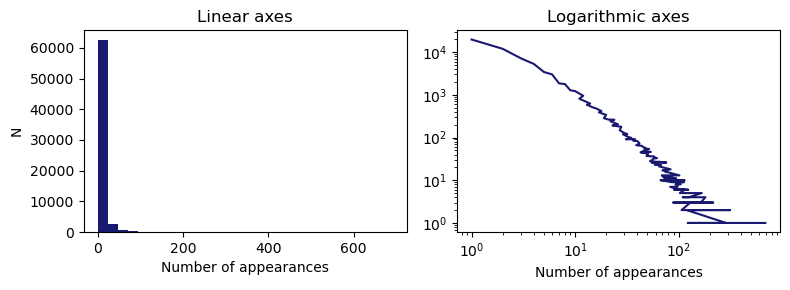

In [400]:
#2 subplots
fig, ax = plt.subplots(1,2, figsize=(8,3))

#group by number of appearances and sort
act = actors.groupby('appearances')['appearances'].count().sort_values(ascending=False)

sbplt = ax[0]
sbplt.hist(actors.appearances, bins=30,color='midnightblue')
sbplt.set_title('Linear axes')
sbplt.set_xlabel('Number of appearances')
sbplt.set_ylabel('N')

sbplt = ax[1]
sbplt.loglog(act.index,act.values,color='midnightblue')
sbplt.set_title('Logarithmic axes')
sbplt.set_xlabel('Number of appearances')
    
fig.tight_layout()
plt.savefig('../figures/power_law.png', bbox_inches='tight')
plt.show()

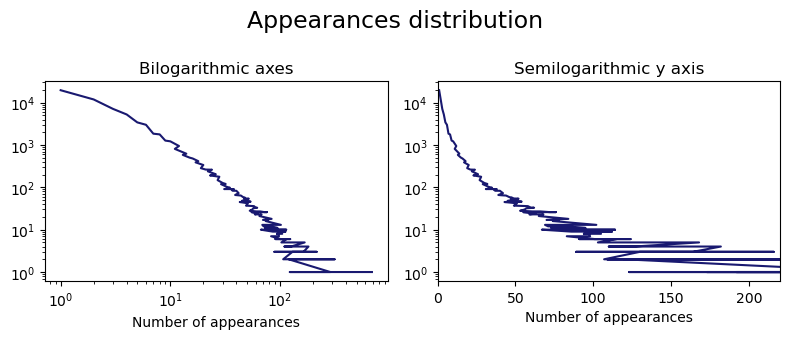

In [401]:
#2 subplots
fig, ax = plt.subplots(1,2, figsize=(8,4))

sbplt = ax[0]
sbplt.loglog(act.index,act.values,color='midnightblue')
sbplt.set_title('Bilogarithmic axes')
sbplt.set_xlabel('Number of appearances')

sbplt = ax[1]
sbplt.semilogy(act.index,act.values,color='midnightblue')
sbplt.set_xlim((0,220))
sbplt.set_title('Semilogarithmic y axis')
sbplt.set_xlabel('Number of appearances')

fig.tight_layout()
fig.suptitle('Appearances distribution', fontsize=17)
fig.subplots_adjust(top=.8, bottom=0.3)
plt.savefig('../figures/pow_law.png', bbox_inches='tight')
plt.show()

The appearances distribution split by gender shows differences between actors and actresses career. The trends are similar (power-law distributions), but there are systematic differences between the two. Moreover, the percentage of actresses is lower than the percentage of actors in the dataset (36%)
This is a possible confounder to be tackled when conducting the observational study.

In the second graphs below (semilogarithmic y axis), the power law is further confirmed by its typical exponential tail, due to the fact that the considered system has a finite size. A Kolmogorov–Smirnov test is performed to actually verify that the tail is exponential and therefore that we are dealing with a power law. The test is performed on appearances belonging to the interval $[2,10]$, given that 1 is a clear outlier.

Source: O. E. Williams, L. Lacasa & V. Latora, Quantifying and predicting success in show business, Nature Communications, 2019. https://doi.org/10.1038/s41467-019-10213-0

# Confounding factors

In [3]:
#loading up the data set of movie-actor pairs, with only movies that were aired in the US
df = pd.read_csv('movies_us.csv')
#loading up the dataset with actors and their statistics
actors = pd.read_csv('actors_us.csv', index_col = 0)

In [7]:
display(df.sample(), actors.sample())

Unnamed: 0.1  Unnamed: 0     tconst             title  year  \
488802       5736983      732189  tt2002606  The Ant's Scream  2011   

              genres  averageRating  numVotes         Director gender  \
488802  Comedy,Drama            6.5       346  Sameh_Abdulaziz      F   

                actor    titleId  ordering region language        types  \
488802  Rania_Youssef  tt2002606         4     US       \N  imdbDisplay   

       attributes  isOriginalTitle  numVotes_factor  averageRating_adj  
488802         \N                0           0.3952           2.568802

actor  grade_avg  grade_sum  appearances main_genre 2nd_genre  \
94354  Paula_Ilabaca   1.889232   1.889232            1        NaN       NaN   

            director 2nd_director gender  year_avg  
94354  J._Adam_White          NaN      F    2006.0

In [8]:
#working with a subset of the movie-actor dataframe, namely the columns below:
info = df.iloc[:, 2:][['title', 'actor', 'Director', 'genres', 'averageRating_adj']]

#preparing dataframes to get actor-genre matches & directors
act_g = info.drop_duplicates(subset = ['actor']).reset_index()[['actor', 'averageRating_adj']] #get per director
act_d = info.drop_duplicates(subset = ['actor']).reset_index()[['actor', 'averageRating_adj']] #get per genre

In [9]:
#correcting the dataframe splitting
info['genres_corrected'] = info['genres'].apply(lambda x: x.split(','))

#get all the genres an actor has starred in accross his/her career
genres_per_actor = info.groupby('actor').apply(
    lambda x :pd.Series({'genres': x['genres_corrected'].values})).reindex(index = act_g['actor'].values)
print('all genres per actor DONE')

#summing the lists per movie
genres_per_actor['genre_total'] = genres_per_actor['genres'].apply(lambda x : sum(x, [])).apply(
    lambda x : np.nan if len(x) == 0 else x)
print('concatenating lists together DONE')

#assigning these genres to our actor-genre dataframe
act_g['g'] = genres_per_actor['genre_total'].reset_index(drop = True)

all genres per actor DONE
concatenating lists together DONE


In [29]:
#number of unique genres
len(genres_per_movie.drop_duplicates(subset = 'genres_corrected'))

27

In [215]:
#getting a list of genre to movie combinations to plot the genres average imdb rating
genres_per_movie = info[['title', 'averageRating_adj', 'genres_corrected']].drop_duplicates(
    subset = 'title').explode('genres_corrected')

#getting the average genres per movie
genre_ratings = pd.DataFrame(genres_per_movie.groupby('genres_corrected').apply(lambda g: 
                np.mean(g['averageRating_adj']))).reset_index()

#genre std to get the error bars for the plots 
genre_std = pd.DataFrame(genres_per_movie.groupby('genres_corrected').apply(lambda g: 
                np.std(g['averageRating_adj']))).reset_index()

genre_ratings.columns = ['genre', 'grade_avg']
genre_std.columns = ['genre', 'grade_std']

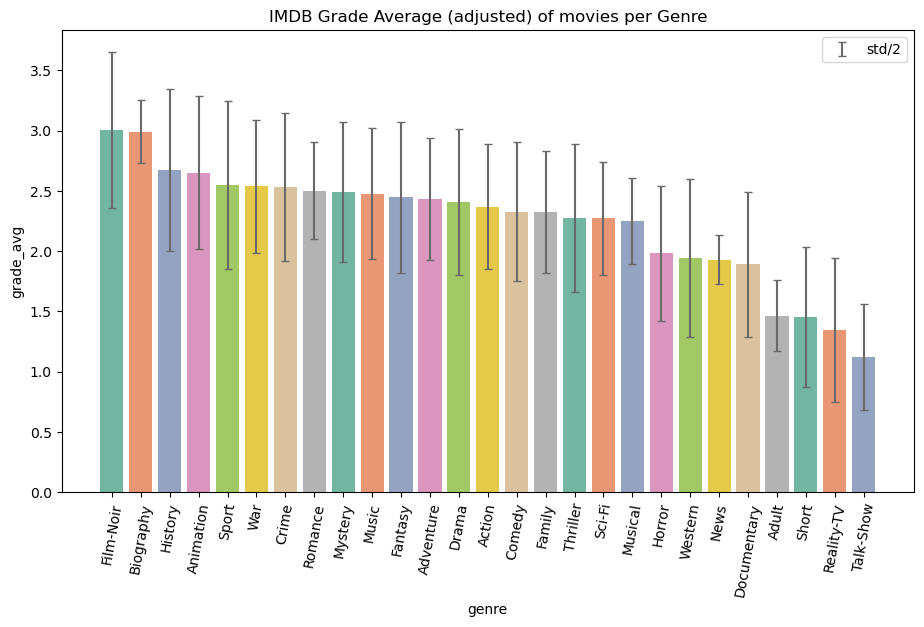

In [519]:
d = genre_ratings.sort_values(by = 'grade_avg', ascending = False).reset_index(drop = True)
genre_std.index = d.index
plt.figure(figsize = (11, 6))
sns.barplot(data = d, x = 'genre', y = 'grade_avg', palette = sns.color_palette("Set2"))
plt.errorbar(x = d['genre'], y = d['grade_avg'], yerr = genre_std['grade_std']/2, ecolor = 'dimgrey', fmt = 'none',
            label = 'std/2', capsize = 3)
plt.xticks(rotation = 80)
#plt.ylim(1, 3.25)
plt.title('IMDB Grade Average (adjusted) of movies per Genre')
plt.legend()
plt.savefig('figs/genrebars.png', bbox_inches = 'tight')
plt.show()

In [521]:
act_g.sample()

actor  averageRating_adj                                   g  \
60881  Paul_Francis           1.988773  [Comedy, Drama, Mystery, Thriller]   

       lenG                                         tuple_list  \
60881     4  [(Comedy, Drama), (Comedy, Mystery), (Comedy, ...   

                                             tuple_listU  
60881  [(Comedy, Drama), (Comedy, Mystery), (Comedy, ...

In [522]:
#unstacking the genre lists per actor, to create unique actor-genre edges
unstacked_genres = act_g.explode('g').reset_index(drop = True)
total_genres = unstacked_genres['g'].unique()

In [523]:
#Creating the bipartite graph
G = nx.Graph()

palette = sns.color_palette("Set2")
color_scheme = [palette[idx%len(palette)] for idx in range(len(total_genres))]
G.add_nodes_from(unstacked_genres['actor'].unique(), bipartite = 0)
G.add_nodes_from(total_genres, bipartite = 1)

print('adding nodes DONE')

unstacked_genres['edges'] = unstacked_genres.apply(lambda x: (x['actor'], x['g']), axis = 1)
G.add_edges_from(unstacked_genres['edges'])

print('adding all edges DONE')

top_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 1}
bottom_nodes = set(G) - top_nodes

print('preparing bipartite folding DONE')

adding nodes DONE
adding all edges DONE
preparing bipartite folding DONE


In [524]:
#folding
K = bipartite.projected_graph(G, top_nodes)

In [525]:
len(color_scheme)

27

In [528]:
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    fig, ax = plt.subplots(figsize=(12, 12))
    pos = nx.circular_layout(G)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=color_scheme, 
                                node_shape=node_shape, node_size = 2500)
    plt.savefig('figs/unweightedgenres.png', bbox_inches = 'tight')
    plt.axis('off')

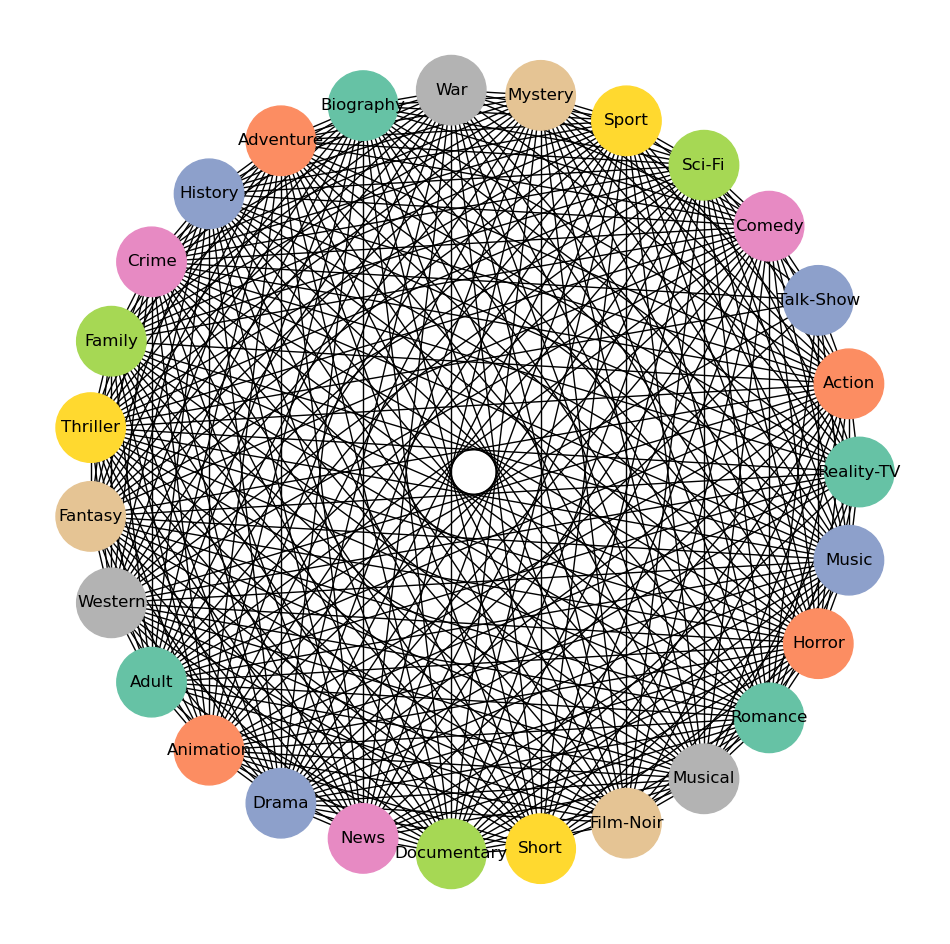

In [529]:
visualize_graph(K)

In [530]:
#Then we are computing another graph, with weighted edges to see the discrepancies between the genres

#actors with only 1 genre cannot influence our genre genre connection matrix
act_g['lenG'] = act_g['g'].apply(lambda x: len(x))
act_g = act_g.query('lenG > 1 & averageRating_adj >= 1') 

#manually calculating the genre projection by calculating the different tuple combinations of genres an actor
#has acted in
act_g['tuple_list'] = act_g['g'].apply(lambda x: 
        [(a,b) for idx, a in enumerate(x) for b in x[idx + 1:]])

#elminate redundancy of tuples aka (Romance, Romance)
act_g['tuple_listU'] = act_g['tuple_list'].apply(lambda x: [t for t in x if t[0] != t[1]])

#example: 
display(act_g['actor'].iloc[0], act_g['tuple_listU'].iloc[0])

'William_Courtenay'

[('Romance', 'Crime'),
 ('Romance', 'Drama'),
 ('Romance', 'Musical'),
 ('Crime', 'Drama'),
 ('Crime', 'Romance'),
 ('Crime', 'Musical'),
 ('Drama', 'Romance'),
 ('Drama', 'Musical'),
 ('Romance', 'Musical')]

In [531]:
#Creating a new weighted graph
G = nx.Graph()
shuffled_g = random.sample(list(total_genres), k = len(total_genres))
G.add_nodes_from(shuffled_g)

In [532]:
#adding all the edges between genres / genre pairs

genre_pairs = []
for index, row in act_g.iterrows():
    genre_pairs += row['tuple_listU']

print("Build the edges DONE")    

#We add those weighted edges to the graph (weight = count of co-occurences)
unique_edges = list(set(genre_pairs))
weights = []
print(len(unique_edges), len(genre_pairs))

Build the edges DONE
631 21109368


In [533]:
# x2 factor happens bc of duplicity (the tuple creation creates an edge for Romance-Crime and Crime Romance)
weight_thr = 50000 * 2 

#adding the weighted edges to the dataframe 
for idx, edge in enumerate(unique_edges):
    
    #progress 
    if (idx%int(len(unique_edges)/5) == 0): print('adding edges ' + str(round(100*idx/len(unique_edges), 1))
                                                  + '% done')
    
    #counting the amount of times that weight appears in the total edge list = weight
    weight_edge = genre_pairs.count(edge)
    weights.append(weight_edge)
    
    if weight_edge > weight_thr:
        G.add_edge(edge[0], edge[1], weight = weight_edge)
    
print("Build the network DONE")  

adding edges 0.0% done
adding edges 20.0% done
adding edges 39.9% done
adding edges 59.9% done
adding edges 79.9% done
adding edges 99.8% done
Build the network DONE


(-1.289322712260829,
 1.2081202465691663,
 -1.2079528951215004,
 1.2079529017442387)

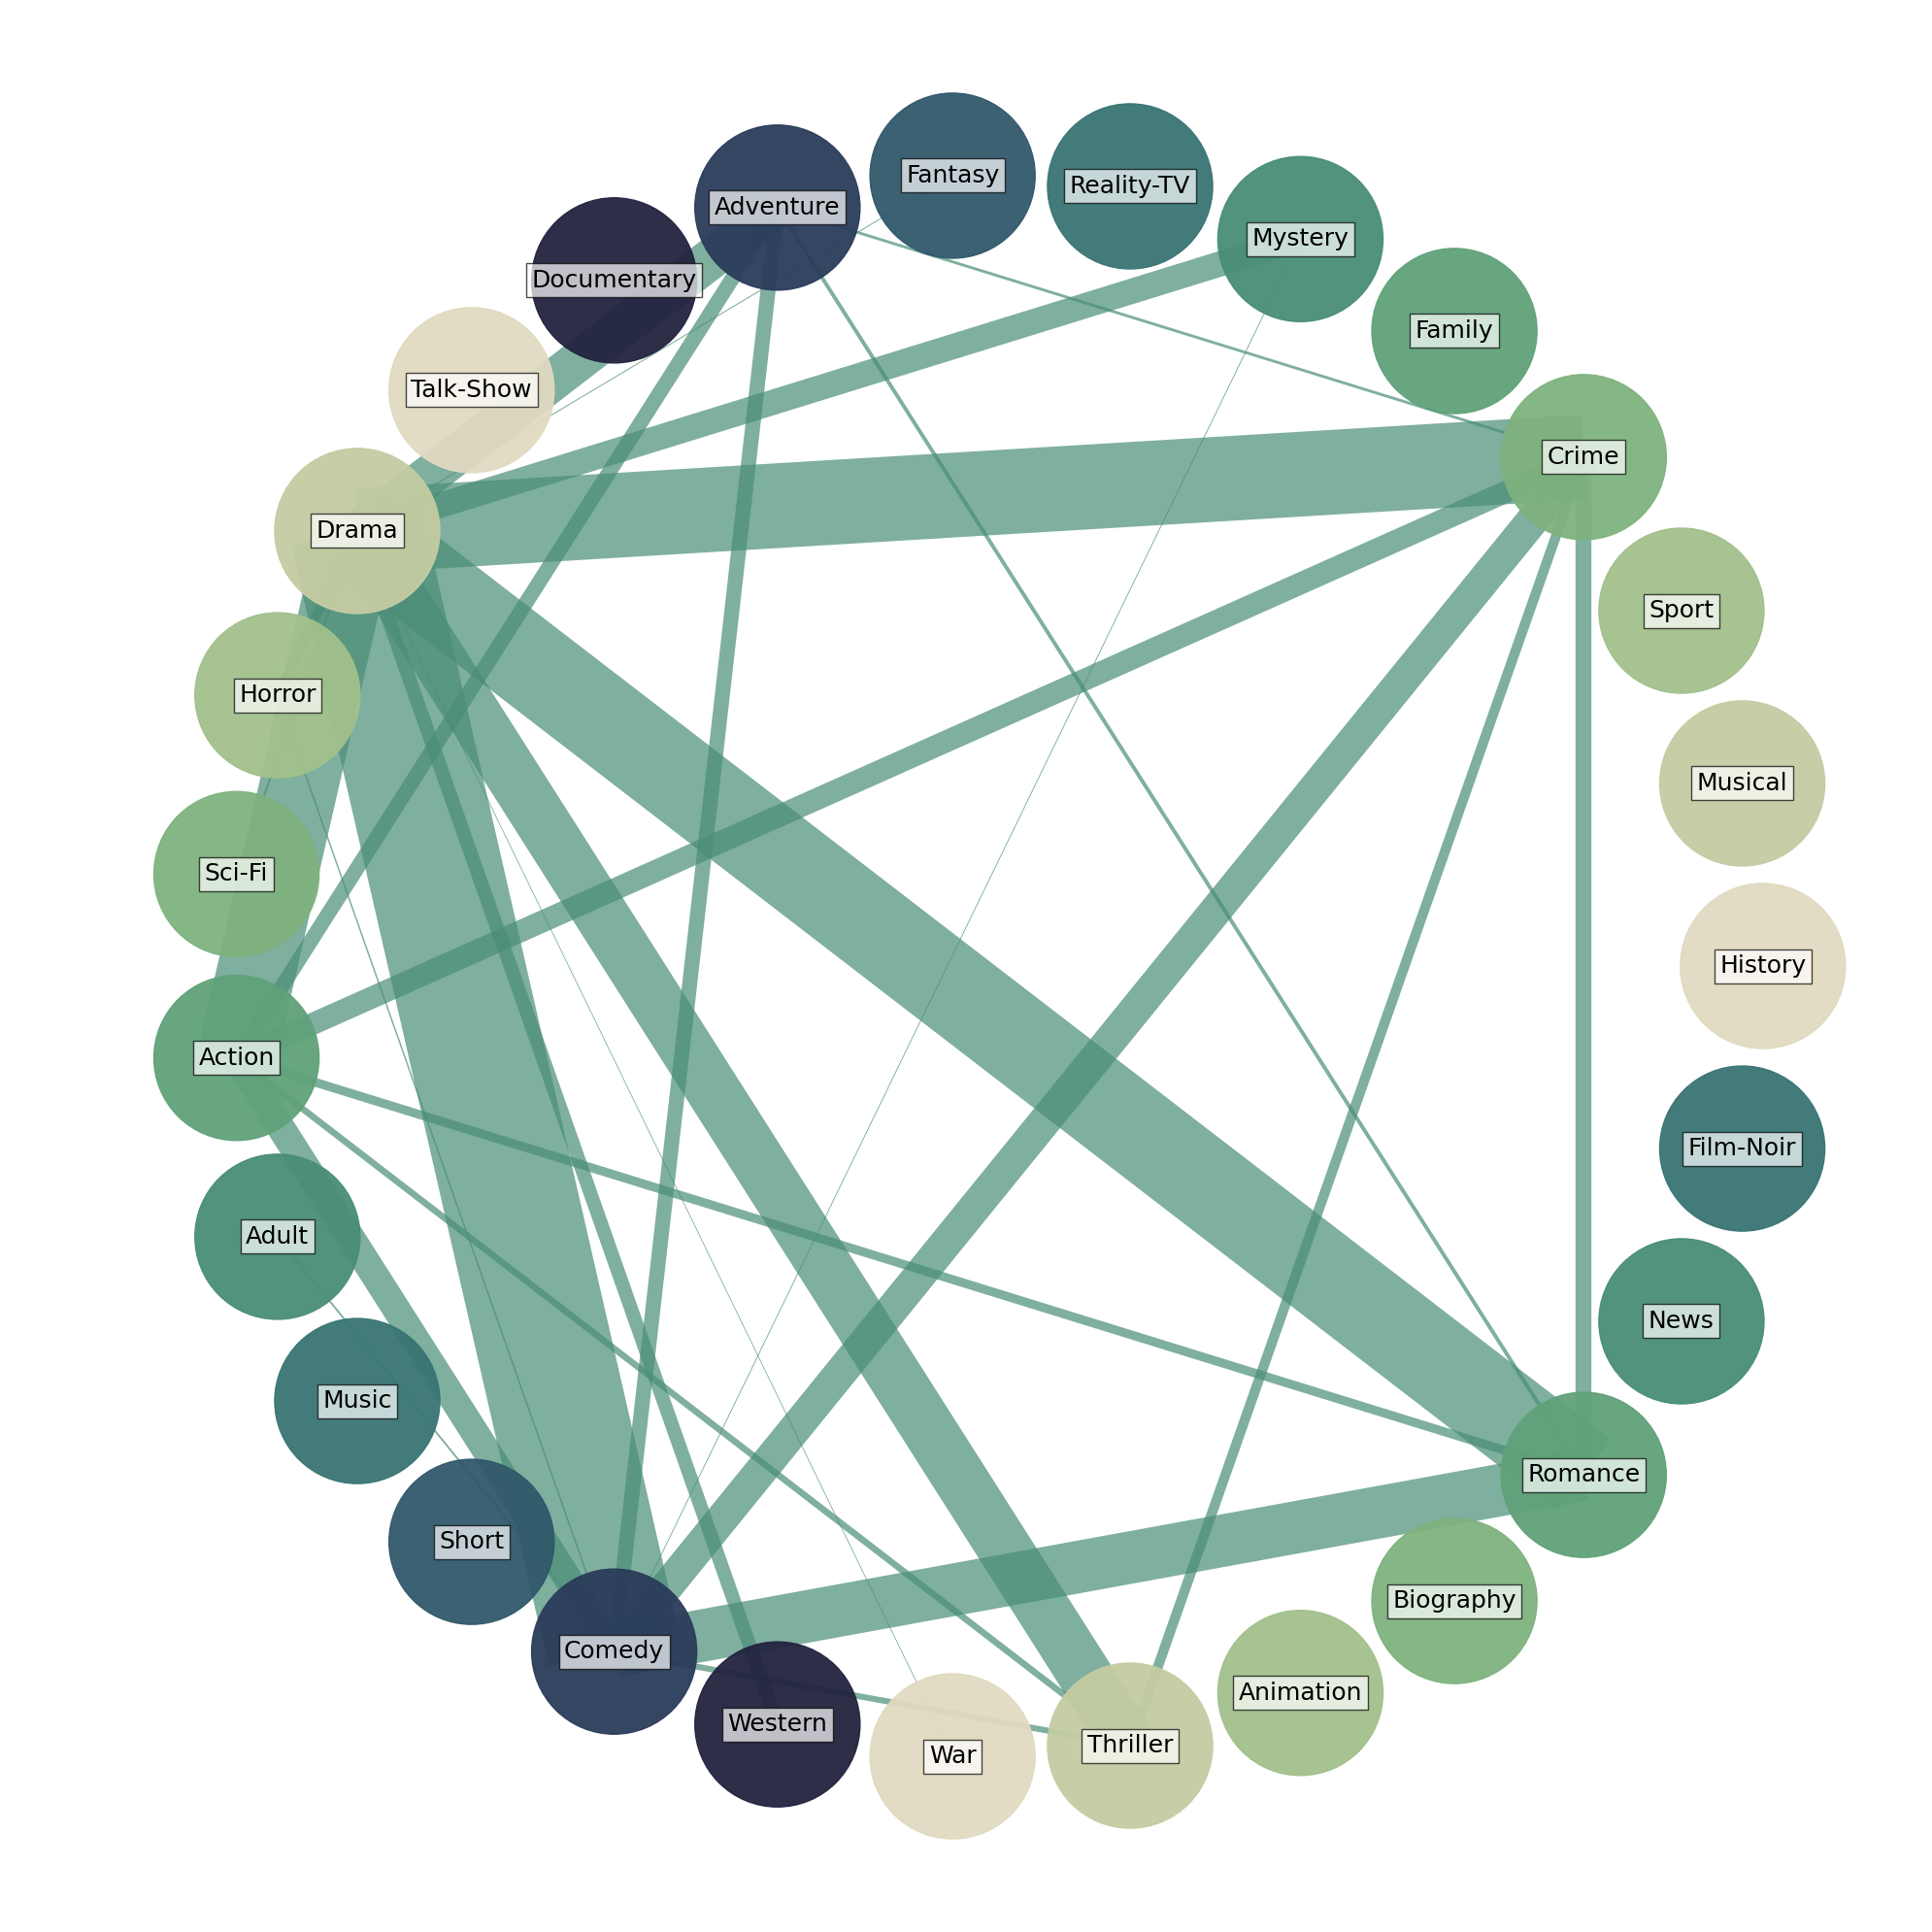

In [535]:
#graph params
node_size = 15000
max_edge_width = 100

#choosing xea
palette = sns.cubehelix_palette(start=.3, rot=-.75, n_colors = 10)
color_scheme = [palette[idx%len(palette)] for idx in range(len(total_genres))]

#minMax scale the weights for graph presentation
weights = np.array([G[u][v]['weight'] for u,v in G.edges()])
weights = (weights - np.min(weights)) / (np.max(weights)-np.min(weights))
weights *= max_edge_width

#layout for visualization
pos = nx.circular_layout(G)

fig, ax = plt.subplots(figsize=(20, 20))

# Visualize graph components
nx.draw_networkx_edges(G, pos, alpha=0.7, width = weights, edge_color=color_scheme[5])
nx.draw_networkx_nodes(G, pos, node_size = node_size, node_color = color_scheme, alpha=0.95)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(G, pos, font_size = 18, bbox = label_options)

# Resize figure for label readibility
plt.savefig('figs/coolweightedgenres.png', bbox_inches = 'tight')
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")

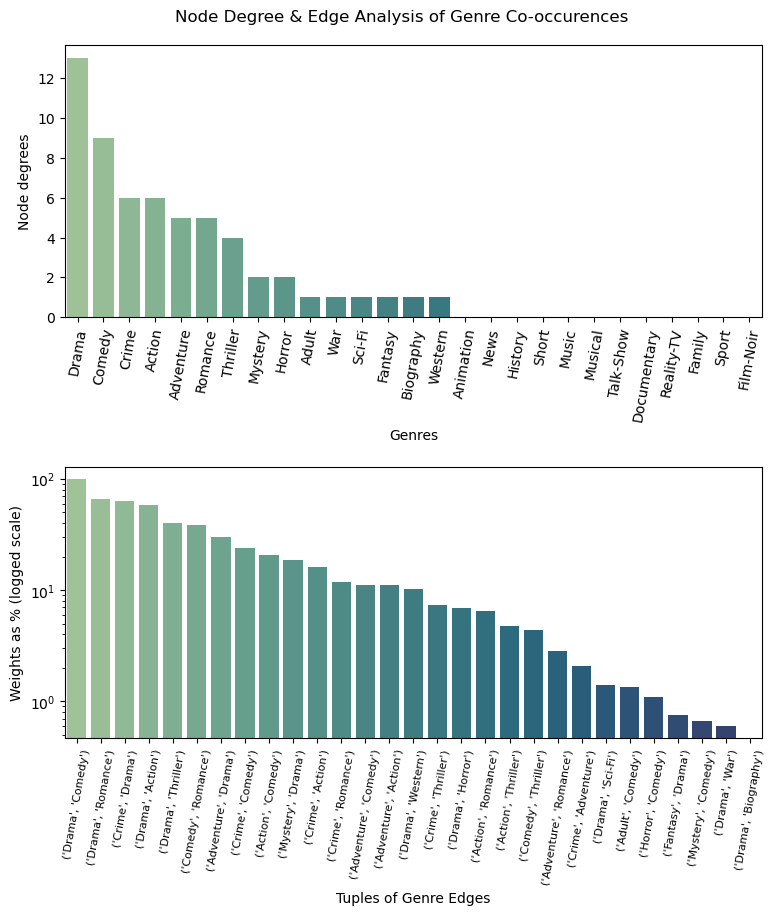

In [536]:
#Getting the biggest weighted edges
biggest_edges = pd.DataFrame([weights, G.edges()], index = ['weights', 'tuples']).T.sort_values(
    by = 'weights', ascending = False).reset_index(drop = True)

#Getting the node degrees & sorting them from highest to lowest
degrees = pd.DataFrame()
for idx, (node, val) in enumerate(G.degree()):
    degrees.loc[idx, 'g'] = node
    degrees.loc[idx, 'deg'] = val

degrees = degrees.sort_values(by = 'deg', ascending = False).reset_index(drop = True)

fig, ax = plt.subplots(2, 1, figsize = (9, 9))

#plotting 2 different bar graphs
                                   
sns.barplot(data = biggest_edges, x = 'tuples', y = 'weights', ax = ax[1], palette='crest')
ax[1].set_xticklabels(biggest_edges['tuples'], rotation = 80, fontsize = 8)
ax[1].set_yscale('log')
ax[1].set_ylabel('Weights as % (logged scale)')
ax[1].set_xlabel('Tuples of Genre Edges')
sns.barplot(data = degrees, x = 'g', y = 'deg', ax = ax[0], palette = 'crest')
ax[0].set_xticklabels(degrees['g'], rotation = 80, fontsize = 10)
ax[0].set_xlabel('Genres')
ax[0].set_ylabel('Node degrees')
fig.suptitle('Node Degree & Edge Analysis of Genre Co-occurences', y = 0.92)

plt.subplots_adjust(hspace = 0.55)
plt.savefig('figs/graphstatsgenre.png', bbox_inches = 'tight')
plt.show()

In [ ]:
#Directors

In [537]:
directors = info.drop_duplicates(subset = ['Director']).reset_index()[['Director']]

#getting different statistics for each director, number of movies & imdb grade average over their career
list_per_director = info.groupby('Director').apply(lambda x : np.mean(x['averageRating_adj'])).reindex(
    index = directors['Director'].values)
directors['grade_avg'] = list_per_director.values
print("grade average done")

#grade 95% confidence interval
list_per_director = info.groupby('Director').apply(lambda x: np.std(x['averageRating_adj'])).reindex(
                    index = directors['Director'].values)
directors['grade_std'] = list_per_director.values

print('grade stf done')

#number of movies per director
appearances_per_director = info.groupby('Director').apply(lambda d: len(pd.Series(d['title']).unique())).reindex(
    index = directors['Director'].values).reset_index(drop = True)
directors['appearances'] = appearances_per_director


print("appearances done")

grade average done
grade stf done
appearances done


In [539]:
directors.sample()

Director  grade_avg  grade_std  appearances
32739  Mohamed_Radi   1.891467   0.266819            2

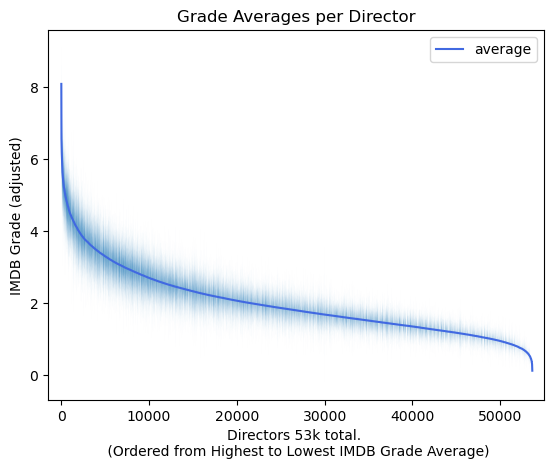

In [540]:
grade_avg = directors.sort_values(by = 'grade_avg', ascending = False).reset_index(drop = True)['grade_avg']
gradeSTD= directors.sort_values(by = 'grade_avg', ascending = False).reset_index(drop = True)['grade_std']


sns.lineplot(x = grade_avg.index, y = grade_avg.values, label = 'average', color = 'royalblue')
plt.fill_between(grade_avg.index, grade_avg.values - gradeSTD.values, 
                grade_avg.values + gradeSTD.values, alpha = 1)

plt.xlim(-1500, 55000)
plt.title('Grade Averages per Director')
plt.ylabel('IMDB Grade (adjusted)')
plt.xlabel('Directors 53k total. \n (Ordered from Highest to Lowest IMDB Grade Average)')
plt.savefig('figs/directorgradesline.png', bbox_inches = 'tight')
plt.show()

In [507]:
#network of co-acting directors

In [541]:
#Number of 1 movie directors
print('percentage of 1 movie directors: ', len(directors[directors['appearances'] == 1])/len(directors))
#arbitrary score of directors to showcase actor 
directors['product'] = minMaxScale(np.log(directors['appearances'])) + minMaxScale(directors['grade_avg'])

percentage of 1 movie directors:  0.643249892825856


In [542]:
#sorting by the product of appearances & grade average to observe directors with similar actor casts 
directors = directors.sort_values(by = 'product', ascending = False).reset_index(drop = True)
top_dir = directors.head(25)['Director'].values.tolist()
print('top directors DONE')

directors_per_actor = info.groupby('actor').apply(
    lambda x :pd.Series({'dir': x['Director'].values})).reindex(index = act_d['actor'].values)

#getting director list in the top actors
directors_per_actor['dir'] = directors_per_actor['dir'].apply(lambda x: pd.Series(
    [i for i in x if i in top_dir]).unique().tolist())
directors_per_actor['len_dir'] = directors_per_actor['dir'].apply(lambda x: len(x))
print('got unique directors per actor DONE')

#get exlcusively actors with movies with the top directors & more than 1 director from the top directors
#unstacked_dir = directors_per_actor.reset_index().explode('dir').reset_index(drop = True)
act_dir = directors_per_actor.query('len_dir > 1').reset_index()

#tuple creation with in directors
act_dir['tuple_list'] = act_dir['dir'].apply(lambda x: 
        [(a,b) for idx, a in enumerate(x) for b in x[idx + 1:]])
act_dir['tuple_listU'] = act_dir['tuple_list'].apply(lambda x: [t for t in x if t[0] != t[1]])
print('created the unique tuple combinations for actors with different directors DONE')

act_dir['len_dirU'] = act_dir['tuple_listU'].apply(lambda x: len(x))
#get exlcusively actors with movies with the top directors
act_dir = act_dir.query('len_dirU > 0').reset_index(drop = True)

top directors DONE
got unique directors per actor DONE
created the unique tuple combinations for actors with different directors DONE


In [543]:
act_dir.sample()

actor                                dir  len_dir  \
163  Michael_Madsen  [Ridley_Scott, Quentin_Tarantino]        2   

                              tuple_list                          tuple_listU  \
163  [(Ridley_Scott, Quentin_Tarantino)]  [(Ridley_Scott, Quentin_Tarantino)]   

     len_dirU  
163         1

>As for the weight threshold with directors, a meaning full metric would be the average cast size of the directors
or the whole movies dataset * 2 because the way tuples are created with a directionnality information

In [544]:
cast_size = pd.DataFrame(info.groupby('title')['actor'].size())
cast_size.columns = ['count']

info['castSize'] = info['title'].apply(lambda m: cast_size.loc[m, 'count'])

cast_per_dir = info.groupby('Director').apply(lambda x: np.mean(x['castSize']))
print('calculating average cast per director')
directors['avg_cast'] = directors['Director'].apply(lambda d: cast_per_dir.loc[d])
print('aggregating average cast to sorted list of directors')

calculating average cast per director
aggregating average cast to sorted list of directors


In [545]:
np.mean(directors.iloc[:25,:]['avg_cast'])

13.270320399459095

Build the edges DONE
Unique Edges: 268 Total Edges: 605
Build the network DONE


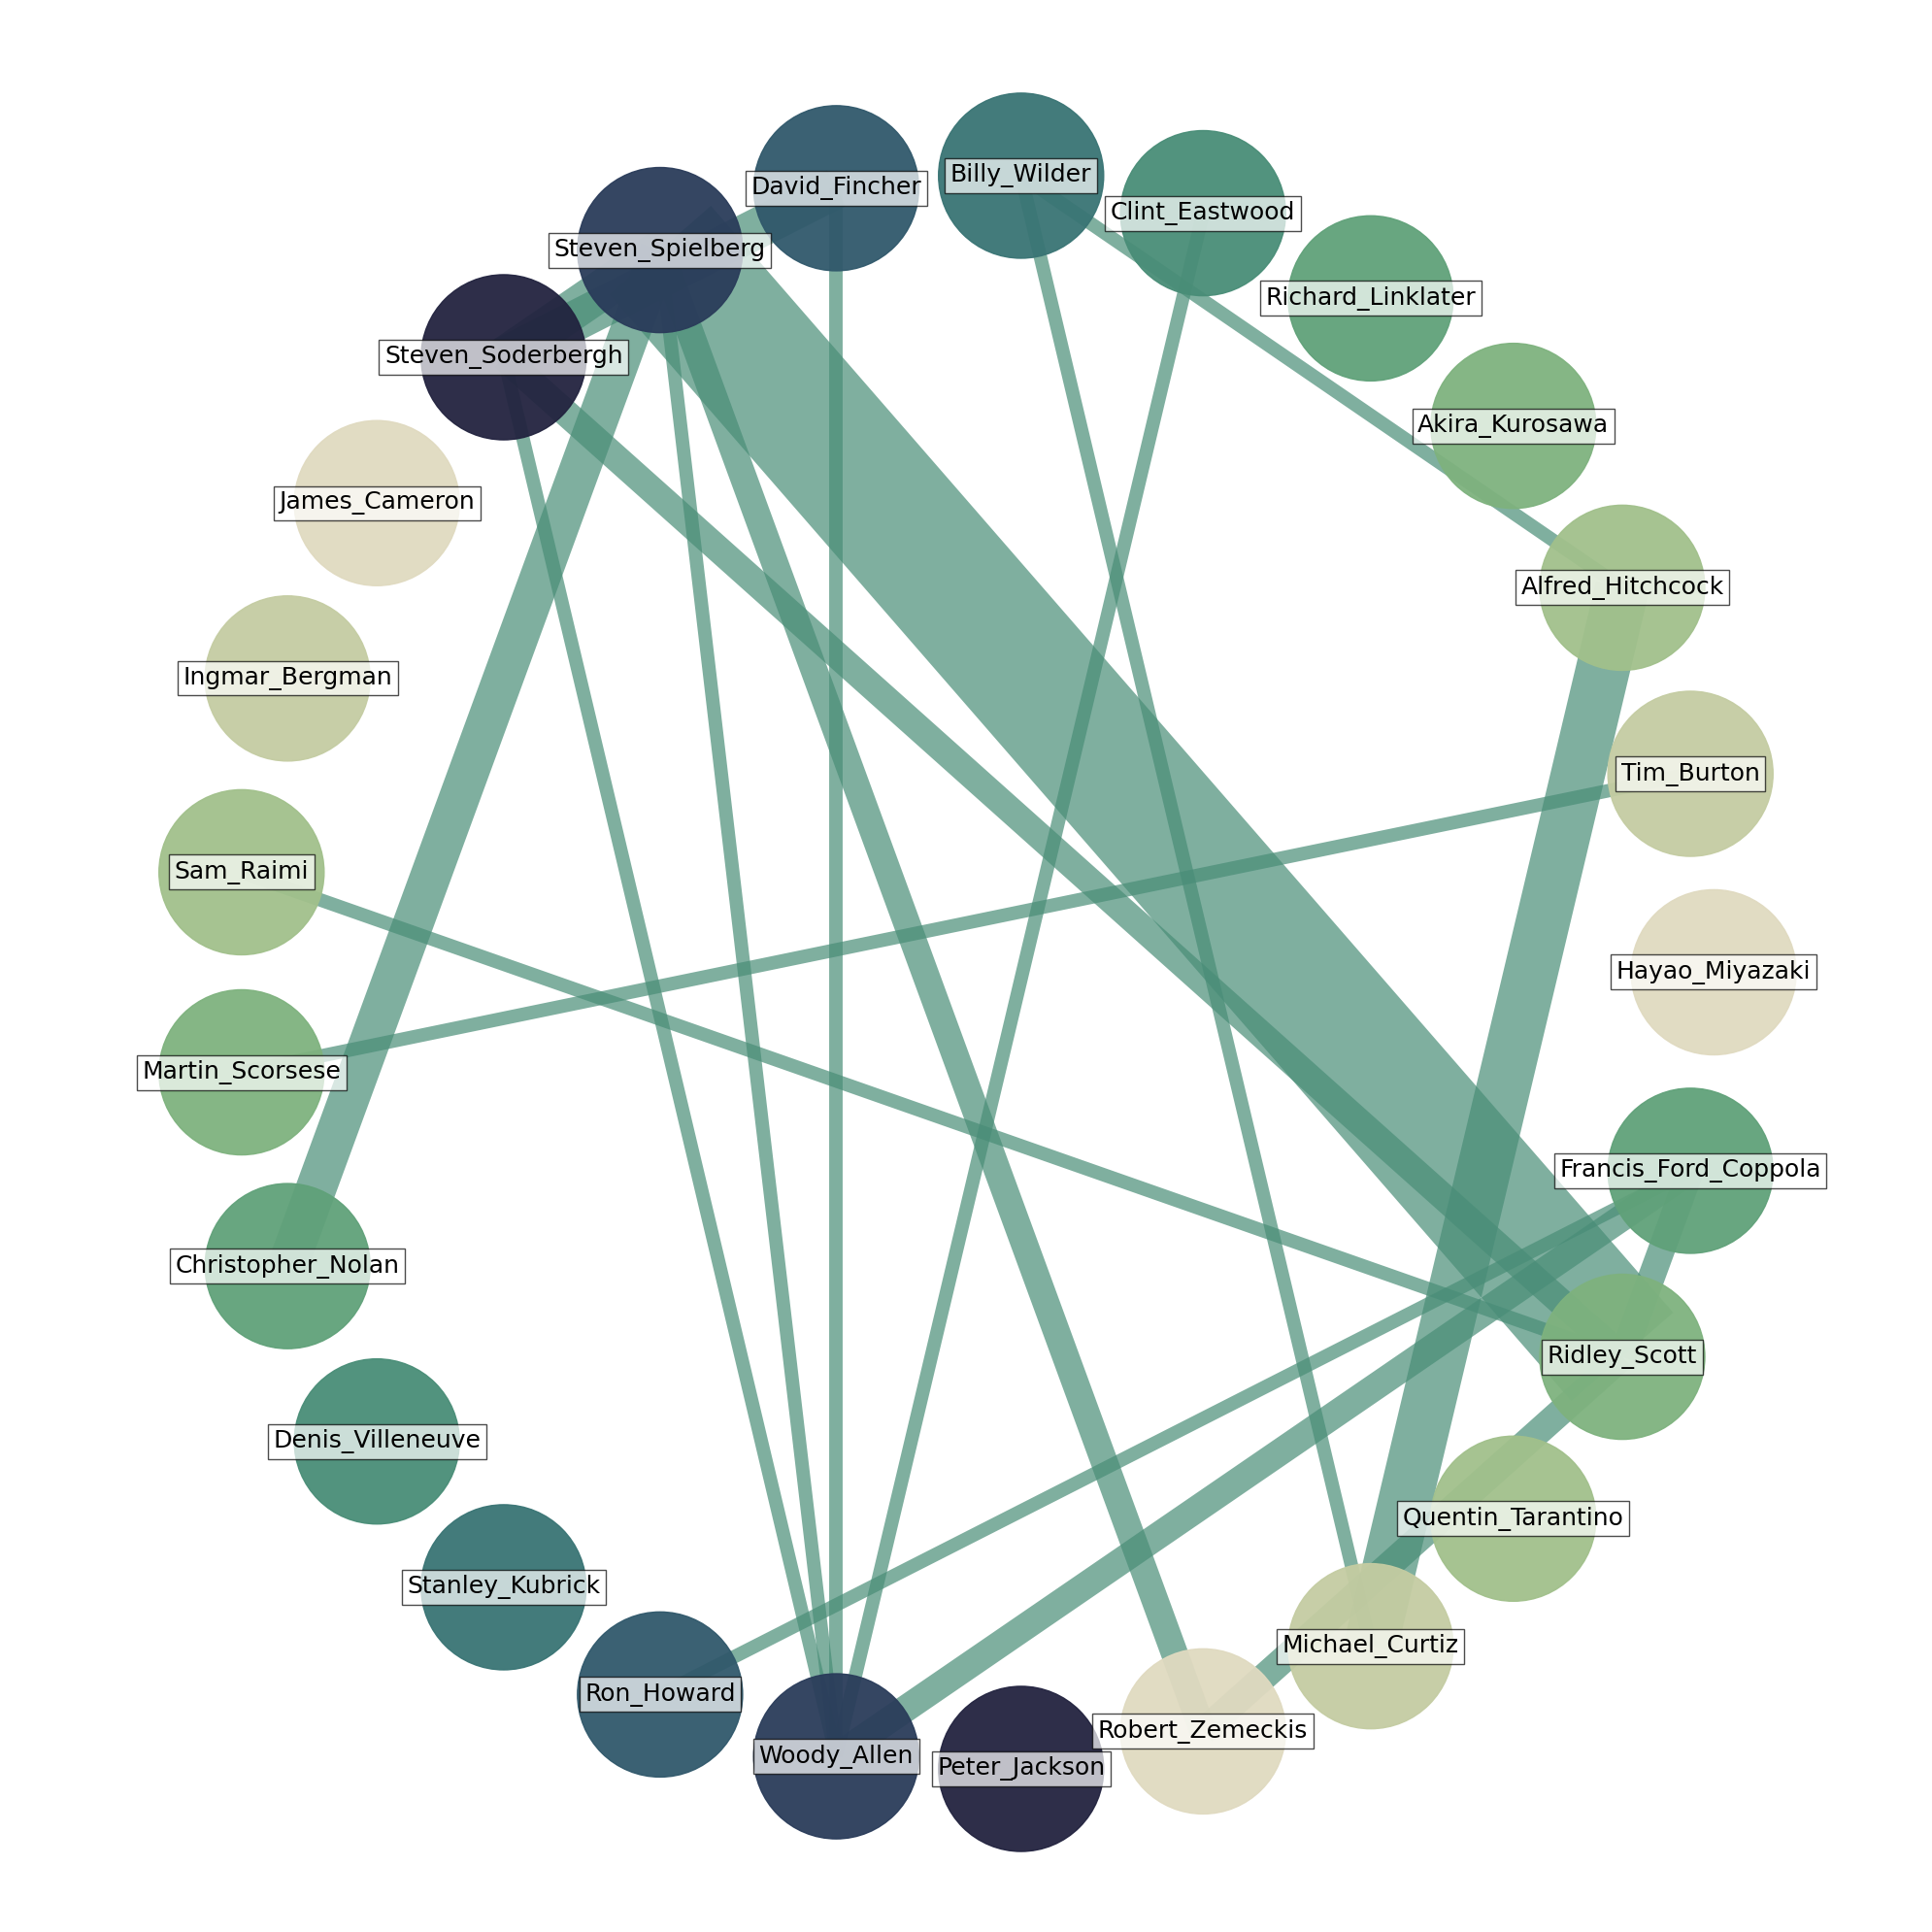

In [563]:
D = nx.Graph()
shuffled = random.sample(top_dir, k = len(top_dir))
D.add_nodes_from(shuffled)
len(top_dir)

dir_pairs = []
for index, row in act_dir.iterrows():
     dir_pairs += row['tuple_listU']

print("Build the edges DONE")    

#We add those weighted edges to the graph (weight = count of co-occurences)
unique_edges = list(set(dir_pairs))
weights = []
print('Unique Edges:', len(unique_edges), 'Total Edges:', len(dir_pairs))

weight_thr = 3

for edge in unique_edges:
    weight_edge = dir_pairs.count(edge)
    weights.append(weight_edge)
    
    if weight_edge > weight_thr:
        D.add_edge(edge[0], edge[1], weight = weight_edge)
    
print("Build the network DONE") 
#graph params
node_size = 15000
max_edge_width = 100

#choosing xea
palette = sns.cubehelix_palette(start=.3, rot=-.75, n_colors = 10)
color_scheme = [palette[idx%len(palette)] for idx in range(len(top_dir))]

#minMax scale the weights for graph presentation
weights = np.array([D[u][v]['weight'] for u,v in D.edges()])
weights = (weights - np.min(weights)) / (np.max(weights)-np.min(weights))
weights *= max_edge_width

#layout for visualization
pos = nx.circular_layout(D)

fig, ax = plt.subplots(figsize=(20, 20))

# Visualize graph components
nx.draw_networkx_edges(D, pos, alpha=0.7, width = weights, edge_color=color_scheme[5])
nx.draw_networkx_nodes(D, pos, node_size = node_size, node_color = color_scheme, alpha=0.95)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(D, pos, font_size = 18, bbox = label_options)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.savefig('figs/coolgraphdir.png', bbox_inches = 'tight')
plt.show()

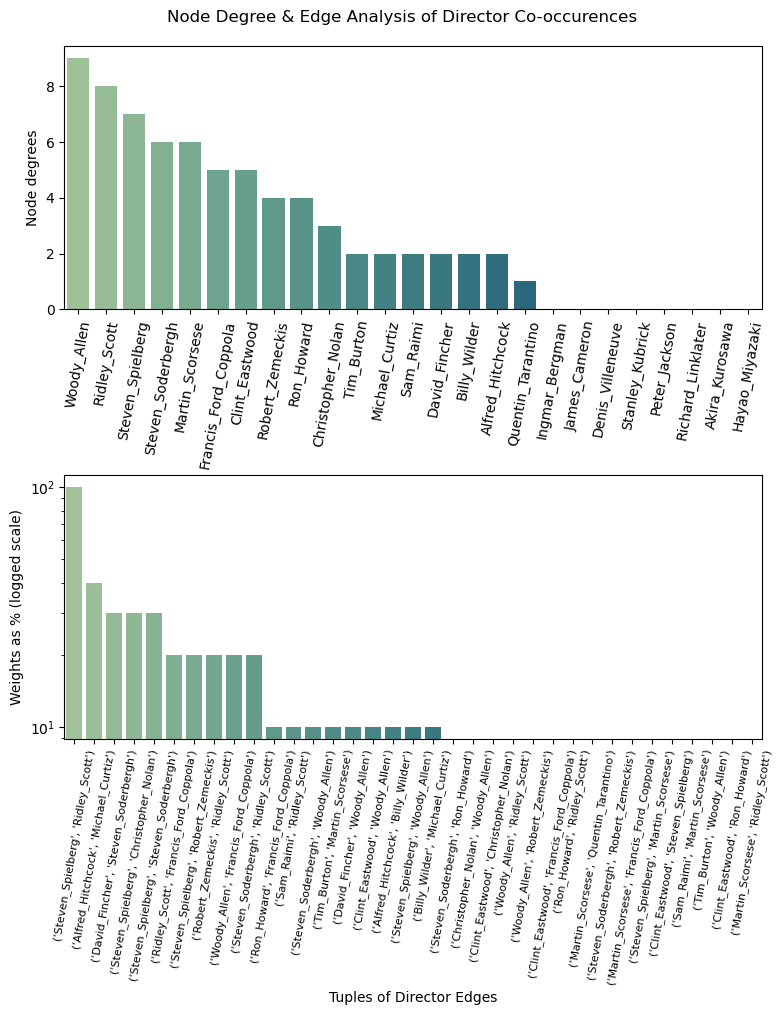

In [564]:
#Getting the biggest weighted edges
biggest_edges = pd.DataFrame([weights, D.edges()], index = ['weights', 'tuples']).T.sort_values(
    by = 'weights', ascending = False).reset_index(drop = True)

#Getting the node degrees & sorting them from highest to lowest
degrees = pd.DataFrame()
for idx, (node, val) in enumerate(D.degree()):
    degrees.loc[idx, 'g'] = node
    degrees.loc[idx, 'deg'] = val

degrees = degrees.sort_values(by = 'deg', ascending = False).reset_index(drop = True)

fig, ax = plt.subplots(2, 1, figsize = (9, 9))

#plotting 2 different bar graphs
                                  
sns.barplot(data = biggest_edges, x = 'tuples', y = 'weights', ax = ax[1], palette='crest')
ax[1].set_xticklabels(biggest_edges['tuples'].values.tolist(), rotation = 80, fontsize = 8)
ax[1].set_yscale('log')
ax[1].set_ylabel('Weights as % (logged scale)')
ax[1].set_xlabel('Tuples of Director Edges')
sns.barplot(data = degrees, x = 'g', y = 'deg', ax = ax[0], palette = 'crest')
ax[0].set_xticklabels(degrees['g'], rotation = 80, fontsize = 10)
ax[0].set_xlabel('Directors')
ax[0].set_ylabel('Node degrees')
fig.suptitle('Node Degree & Edge Analysis of Director Co-occurences', y = 0.92)

plt.subplots_adjust(hspace = 0.63)
plt.savefig('figs/graphstatsdir.png', bbox_inches = 'tight')
plt.show()

In [432]:
#more than once directors
mtod = directors.query('appearances > 1').reset_index(drop = True) 
print(len(mtod))

#getting cast_list per movie
cast_list_movie = pd.DataFrame(info.groupby('title').apply(lambda m: m['actor'].values.tolist())).reset_index()
cast_list_movie.columns = ['movie', 'cast']
print('getting cast per movie DONE')

#getting movies per director
movies_per_dir = pd.DataFrame(info.groupby('Director').apply(lambda d: 
                    pd.Series(d['title']).unique().tolist()), columns = ['movies'])
print('list of movies per director DONE')

for idx, d in enumerate(mtod['Director'].values.tolist()):
    
    if (idx % 5000 == 0): print('calculating total actors per dir at ' + str(round(100*idx/len(mtod), 1)) + '%')
                              
    movies = cast_list_movie[cast_list_movie['movie'].isin(movies_per_dir.loc[d, 'movies'])]
    total_cast = []                   
    for jdx, m in movies.iterrows():
        total_cast += list(m['cast'])
    
    #dataframe of total cast & repitions counts
    dtc = pd.DataFrame(pd.DataFrame(total_cast, columns = ['actors']).groupby('actors'
            ).size(), columns = ['count'])['count'] - 1 #minus one to count repetitions
    repetitions = sum(dtc.values.tolist())
    mtod.loc[idx, 'n_movies'] = len(movies)
    mtod.loc[idx, 'repetitions'] = repetitions
    
print('director repetitions done')

19140
getting cast per movie DONE
list of movies per director DONE
calculating total actors per dir at 0.0%
calculating total actors per dir at 26.1%
calculating total actors per dir at 52.2%
calculating total actors per dir at 78.4%
director repetitions done


In [565]:
mtod['retain_rate'] = mtod['repetitions']/mtod['appearances']
retain_percentage = pd.DataFrame([len(mtod[mtod['retain_rate'] == 0]
                    )/len(mtod), len(mtod[mtod['retain_rate'] != 0])/len(mtod)], 
                                 index = ['no retention', 'retention'], columns = ['Directors with'])
retain_percentage

Directors with
no retention        0.348276
retention           0.651724

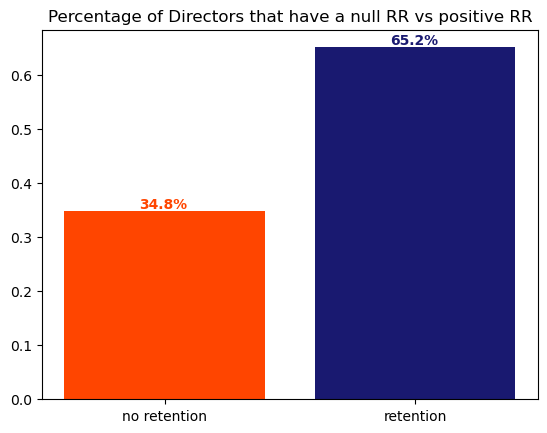

In [566]:
clist = ['orangered', 'midnightblue']
plt.bar(x = retain_percentage.index, height = retain_percentage['Directors with'], color = clist)
plt.title('Percentage of Directors that have a null RR vs positive RR')
for idx, v in enumerate(retain_percentage['Directors with'].values.tolist()):
    plt.text(idx - 0.1, v + 0.005, str(round(100*v, 1))+'%', color = clist[idx], fontweight='bold')

plt.savefig('figs/dirretention.png', bbox_inches = 'tight')
plt.show()

### Gender

In [402]:
#split into actors/actresses
dt1 = actors[actors['gender'] == 'M']
dt2 = actors[actors['gender'] == 'F']

#group by number of appearances and sort
act1 = dt1.groupby('appearances')['appearances'].count().sort_values(ascending=False)
act2 = dt2.groupby('appearances')['appearances'].count().sort_values(ascending=False)

In [403]:
#fraction of actresses in the dataset
print('Fraction of actresses in the dataset: ' + str(len(dt2)/len(actors)))

Fraction of actresses in the dataset: 0.39285553064387496


The results of the Kolmogorov–Smirnov test are diplayed in the cell below, for the overall dataset and for the two datasets split on gender. The p-values are larger than 0.05, therefore the null-hypothesis of the distributions being exponential cannot be rejected.

In [416]:
#kolmogorov-smirnov test for exponential distribution
from statsmodels.stats import diagnostic

print('Overall dataset: ' + str(diagnostic.kstest_normal(act.values[2:10], dist = 'exp'))) #overall dataset
print('Actors dataset: ' + str(diagnostic.kstest_normal(act1.values[2:10], dist = 'exp'))) #actors dataset
print('Actresses dataset: ' + str(diagnostic.kstest_normal(act2.values[2:10], dist = 'exp'))) #actresses dataset

Overall dataset: (0.3241404179985075, 0.10978663640955186)
Actors dataset: (0.3315073746796858, 0.09229780590906406)
Actresses dataset: (0.3045067718580039, 0.1698311465443847)


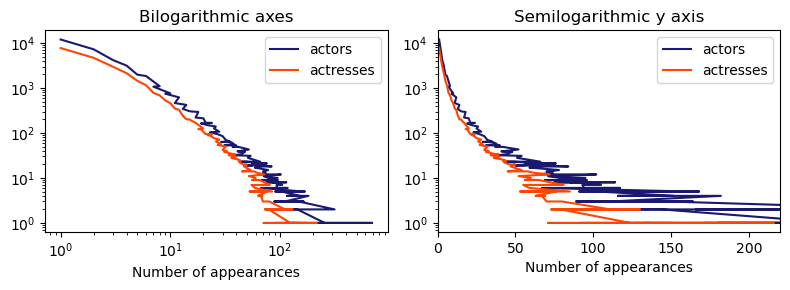

In [504]:
#2 subplots
fig, ax = plt.subplots(1,2, figsize=(8,3))

sbplt = ax[0]
sbplt.loglog(act1.index,act1.values, label='actors', color='midnightblue')
sbplt.loglog(act2.index,act2.values, label='actresses', color='orangered')
sbplt.set_title('Bilogarithmic axes')
sbplt.set_xlabel('Number of appearances')
sbplt.legend()

sbplt = ax[1]
sbplt.semilogy(act1.index,act1.values, label='actors', color='midnightblue')
sbplt.semilogy(act2.index,act2.values, label='actresses', color='orangered')
sbplt.set_xlim((0,220))
sbplt.set_title('Semilogarithmic y axis')
sbplt.set_xlabel('Number of appearances')
sbplt.legend()

fig.tight_layout()
plt.savefig('../figures/pow_gender.png', bbox_inches='tight')
plt.show()

An Mann-Whitney U test is also performed to verify if the difference between the distributions of datasets split on gender is statistically significant. The resulting p-values are lower than the imposed threshold (0.05), therefore the null hypothesis that the averages are equal is rejected. There is a gender bias in the attribution of jobs.

In [418]:
#appearances of actors/actresses
stats.mannwhitneyu(dt1.appearances, dt2.appearances) #mann whitney u test

MannwhitneyuResult(statistic=534502483.0, pvalue=0.00103992037166748)

From the following bar plots, the gender difference in average appearances is visible (also accounting for the 95% confidence intervals). However, in terms of ratings in the movie they starred in, there is no significant difference.

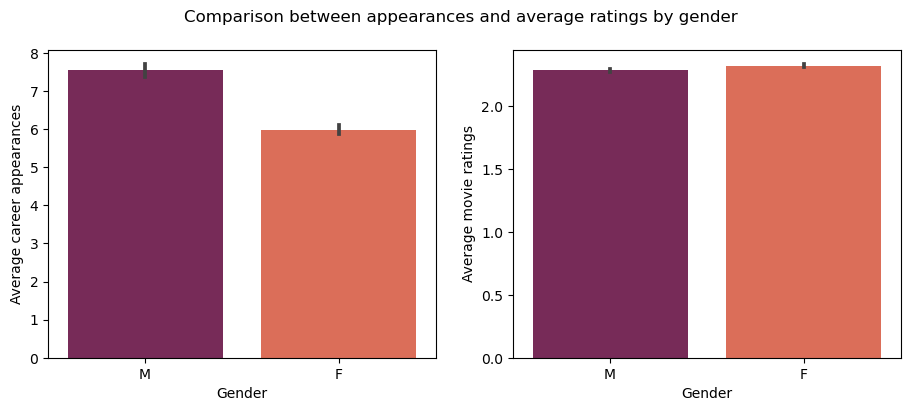

In [462]:
#bar plot with 95% confidence intervals
import seaborn as sns

#3 subplots
fig, ax = plt.subplots(1,2, figsize=(11,4))

sbplt = ax[0]
sns.barplot(ax=ax[0], x="gender", y="appearances", data=actors, palette='rocket')
sbplt.set_ylabel('Average career appearances')
sbplt.set_xlabel('Gender')

sbplt = ax[1]
sns.barplot(ax=ax[1], x="gender", y="grade_avg", data=actors, palette='rocket')
sbplt.set_ylabel('Average movie ratings')
sbplt.set_xlabel('Gender')
    
#fig.tight_layout()
plt.rcParams.update({'font.size': 10})
fig.suptitle('Comparison between appearances and average ratings by gender')
plt.savefig('../figures/gender1.png', bbox_inches='tight')
plt.show()

# Observational study

Supported by rich-get-richer mechanism assumption, the treatment group will be the group with the higher number of appearances. We want to capture the influence of being part of one of these groups on the movie ratings.

According to the Pareto principle, the threshold between the number of appearances that dominate and the long tail of the power-law distribution is defined by the 80/20 rule. Basically, 20% of the people detain the most number of appearances. Therefore, the splitting of the dataset will be carried out based on the 80th percentile of the distribution, more representative than the mean or the median when considering power-law distributions.

In [409]:
#median
print('The median of the distribution is ' + str(np.median(actors.appearances)))
print('The mean of the distribution is ' + str(np.mean(actors.appearances)))
print('The 80th percentile of the distribution is ' + str(np.percentile(actors.appearances,80)))

The median of the distribution is 3.0
The mean of the distribution is 6.932377326692448
The 80th percentile of the distribution is 8.0


In [410]:
#define threshold
threshold = np.percentile(actors.appearances,80)
print(threshold)

8.0


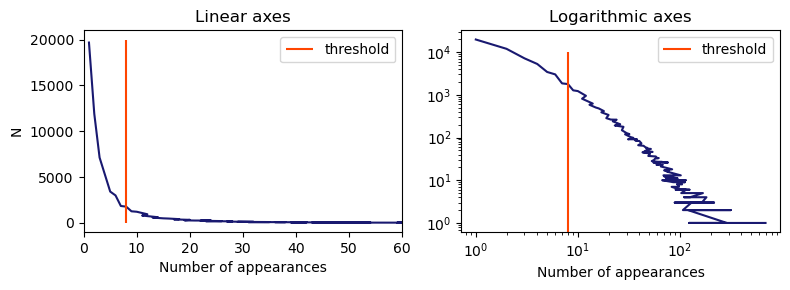

In [412]:
#2 subplots
fig, ax = plt.subplots(1,2, figsize=(8,3))

sbplt = ax[0]
sbplt.plot(act.index,act.values,color='midnightblue')
sbplt.vlines(threshold,0,20000,label='threshold',color='orangered')
sbplt.set_xlim(0,60)
sbplt.set_title('Linear axes')
sbplt.set_xlabel('Number of appearances')
sbplt.set_ylabel('N')
sbplt.legend()

sbplt = ax[1]
sbplt.loglog(act.index,act.values,color='midnightblue')
sbplt.vlines(threshold,0,1e4,label='threshold',color='orangered')
sbplt.set_title('Logarithmic axes')
sbplt.set_xlabel('Number of appearances')
sbplt.legend()
    
fig.tight_layout()
plt.savefig('../figures/threshold.png', bbox_inches='tight')
plt.show()

### Propensity score matching

To limit the effect of confounders, the individuals of the groups will be matched on propensity score, namely the probability of being in the treatment group based on observed covariates. The considered observed covariates will be:

- Main genre of the movies they acted in;
- Main directors of the movies they acted in;
- Birthdate;
- Average date of movie release
- Gender.

The **genre** could have a strong confounding effect, given that Action/Adventure movies have generally more viewers than other movie categories, therefore, including main genre of the actor's career would limit the effect of such a confounder.

The **directors** may play a fundamental role in the success of an actor, given the preferences of directors for specific actors (e.g., Quentin Tarantino preferences for Brad Pitt or Samuel L. Jackson).

Regarding the **gender**, to further balance the dataset, the matching will be *perfect* on gender. This means that an actors will be matched with another actor and an actress with another actress.

**Birthdate** is not considered as a confounder because highly correlated with appearances. Indeed, a linear regression implemented with birthdate as a predictor and appearances (or the binary variable treatment) showed multicollinearity.

In [436]:
#proof of multicollinearity
import statsmodels.formula.api as smf #for linear and logistic regression

mod = smf.ols(formula='appearances ~ birth_year',
              data=actors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            appearances   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     10.86
Date:                Wed, 21 Dec 2022   Prob (F-statistic):          1.59e-299
Time:                        18:54:07   Log-Likelihood:            -2.7487e+05
No. Observations:               66457   AIC:                         5.501e+05
Df Residuals:                   66270   BIC:                         5.518e+05
Df Model:                         186                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              9.0000     15.159      0.594      0.553     -20.711      38.711
birth_year[T.1685]    -6.0000     21.438     -0.280      0.780     -48.018      36.018
birth_year[T.1725]    -8.0000     21.438     -0.373      0.709     -50.018      34.018
birth_year[T.1757]    -7.0000     21.438     -0.327      0.744     -49.018      35.018
birth_year[T.1770]    -7.0000     21.438     -0.327      0.744     -49.018      35.018
birth_year[T.1771]    -7.0000     21.438     -0.327      0.744     -49.018      35.018
birth_year[T.1812]    -7.0000     21.438     -0.327      0.744     -49.018      35.018
birth_year[T.1814]    -8.0000     21.438     -0.373      0.709     -50.018      34.018
birth_year[T.1817]     1.0000     21.438      0.047      0.963     -41.018      43.018
birth_year[T.1830]    -8.0000     21.438     -0.373      0.709     -50.018      34.018
birth_year[T.1835]    -8.0000     21.438     -0.373      0.709     -50.018      34.018
birth_year[T.1837]    -8.0000     21.438     -0.373      0.709     -50.018      34.018
birth_year[T.1838]    -8.0000     21.438     -0.373      0.709     -50.018      34.018
birth_year[T.1841]    -8.0000     17.504     -0.457      0.648     -42.308      26.308
birth_year[T.1842]    -4.0000     18.566     -0.215      0.829     -40.389      32.389
birth_year[T.1843]    -1.3333     17.504     -0.076      0.939     -35.641      32.974
birth_year[T.1844]    -8.0000     21.438     -0.373      0.709     -50.018      34.018
birth_year[T.1845]    -5.6000     16.606     -0.337      0.736     -38.147      26.947
birth_year[T.1846]    -3.7500     16.948     -0.221      0.825     -36.968      29.468
birth_year[T.1847]    -8.0000     18.566     -0.431      0.667     -44.389      28.389
birth_year[T.1848]     1.2000     16.606      0.072      0.942     -31.347      33.747
birth_year[T.1849]    -5.3333     17.504     -0.305      0.761     -39.641      28.974
birth_year[T.1850]     5.0000     18.566      0.269      0.788     -31.389      41.389
birth_year[T.1851]    -5.6667     16.373     -0.346      0.729     -37.758      26.425
birth_year[T.1852]    -0.8889     15.979     -0.056      0.956     -32.207      30.429
birth_year[T.1853]    -1.8750     16.078     -0.117      0.907     -33.389      29.639
birth_year[T.1854]    -6.4286     16.205     -0.397      0.692     -38.191      25.334
birth_year[T.1855]    -6.3000     15.899     -0.396      0.692     -37.461      24.861
birth_year[T.1856]    -1.1111     15.979     -0.070      0.945     -32.429      30.207
birth_year[T.1857]    -0.7857     15.691     -0.050      0.960     -31.540      29.968
birth_year[T.1858]    -1.5200     15.459     -0.098      0.922     -31.820      28.780
birth_year[T.1859]    -2.8333     15.574     -0.182      0.856     -33.359      27.692
birth_year[T.1860]    -1.4583     15.4

To extract the propensity scores, a logistic regression is trained and applied on the same dataset. This will output the needed probabilities. It is worth mentioning that the ratings are the characteristic that define the success of the movie. Therefore, they are not included in the matching features, otherwise they would bias the process of identification of successful actors.

In [432]:
#number of considered actors
len(actors)

66457

In [433]:
actors.head()

actor  grade_avg   grade_sum  appearances gender     year_avg  \
0     Fred_Astaire   3.856973  177.420767           46      M  2007.000000   
1    Lauren_Bacall   3.668075  176.067605           48      F  1945.666667   
2  Brigitte_Bardot   2.546581  112.049557           44      F  2008.000000   
3     John_Belushi   4.528141   54.337691           12      M  1951.000000   
5   Ingrid_Bergman   3.926664  447.639650          114      F  1937.200000   

  birth_year main_genre 2nd_genre            director      2nd_director  
0       1899    Musical   Romance       Mark_Sandrich   Charles_Walters  
1       1924      Drama   Romance      Jean_Negulesco       Jack_Smight  
2       1934    Romance     Drama     Michel_Boisrond       Roger_Vadim  
3       1949  Adventure    Comedy         John_Landis   Joan_Tewkesbury  
5       1915      Drama   Romance  Roberto_Rossellini  Alfred_Hitchcock

In [434]:
#re-define threshold on cut dataset
threshold = np.percentile(actors.appearances,80)
print(threshold)

8.0


In [435]:
#split into treatment and control groups
actors['treatment'] = (actors['appearances'] > threshold).astype(int)

In [99]:
#predictors
X = actors[{'main_genre','director'}]
#labels
y = actors['treatment']

In [100]:
#convert categorical columns into binary columns
X = pd.get_dummies(X,columns=['main_genre','director'])

In [101]:
X.head()

main_genre_Adult  main_genre_Adventure  main_genre_Animation  \
0                 0                     0                     0   
1                 0                     0                     0   
2                 0                     0                     0   
3                 0                     1                     0   
4                 0                     0                     0   

   main_genre_Biography  main_genre_Comedy  main_genre_Crime  \
0                     0                  0                 0   
1                     0                  0                 0   
2                     0                  0                 0   
3                     0                  0                 0   
4                     0                  0                 0   

   main_genre_Documentary  main_genre_Drama  main_genre_Family  \
0                       0                 0                  0   
1                       0                 1                  0   
2                       0                 0                  0   
3                       0                 0                  0   
4                       0                 1                  0   

   main_genre_Fantasy  ...  director_Óskar_Jónasson  \
0                   0  ...                        0   
1                   0  ...                        0   
2                   0  ...                        0   
3                   0  ...                        0   
4                   0  ...                        0   

   director_Óskar_Thór_Axelsson  director_Ömer_Faruk_Sorak  \
0                             0                          0   
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   

   director_Ömer_Kavur  director_Özcan_Deniz  director_Özer_Feyzioglu  \
0                    0                     0                        0   
1                    0                     0                        0   
2                    0                     0                        0   
3                    0                     0                        0   
4                    0                     0                        0   

   director_Özhan_Eren  director_Ümit_Ünal  director_Þráinn_Bertelsson  \
0                    0                   0                           0   
1                    0                   0                           0   
2                    0                   0                           0   
3                    0                   0                           0   
4                    0                   0                           0   

   director_Þórhildur_Þorleifsdóttir  
0                                  0  
1                                  0  
2                                  0  
3                                  0  
4                                  0  

[5 rows x 24290 columns]

In [102]:
#logistic regression model
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(solver='lbfgs', max_iter=1000)
logistic.fit(X,y) #train

LogisticRegression(max_iter=1000)

In [103]:
#coefficients of predictors
coef = pd.DataFrame(logistic.coef_, columns=X.columns)

In [145]:
intercept = logistic.intercept_
print(intercept)

[-2.31367236]


In [143]:
coef

main_genre_Adult  main_genre_Adventure  main_genre_Animation  \
0          0.503697              0.682463              0.118734   

   main_genre_Biography  main_genre_Comedy  main_genre_Crime  \
0             -0.241809           0.454089          0.552902   

   main_genre_Documentary  main_genre_Drama  main_genre_Family  \
0               -0.949931          0.941334          -0.383027   

   main_genre_Fantasy  ...  director_Óskar_Jónasson  \
0           -0.347448  ...                 0.258714   

   director_Óskar_Thór_Axelsson  director_Ömer_Faruk_Sorak  \
0                      -0.08816                  -0.264035   

   director_Ömer_Kavur  director_Özcan_Deniz  director_Özer_Feyzioglu  \
0            -0.175393              -0.11514                 -0.31301   

   director_Özhan_Eren  director_Ümit_Ünal  director_Þráinn_Bertelsson  \
0            -0.175393           -0.357416                   -0.059584   

   director_Þórhildur_Þorleifsdóttir  
0                          -0.059584  

[1 rows x 24290 columns]

In [107]:
#split into genres and directors coefficients
main_genre_rows = []
director_rows = []

for row in co.columns:
    if row.startswith('main_genre'):
        main_genre_rows.append(row)
    elif row.startswith('director'):
        director_rows.append(row)

In [480]:
#extract and transpose the datasets
coef_genres = co[main_genre_rows].T
coef_directors = co[director_rows].T

In [481]:
#drop the useless part of the labels
coef_genres = coef_genres.rename(index=lambda x: x.replace("main_genre_", ""))
coef_directors = coef_directors.rename(index=lambda x: x.replace("director_", ""))

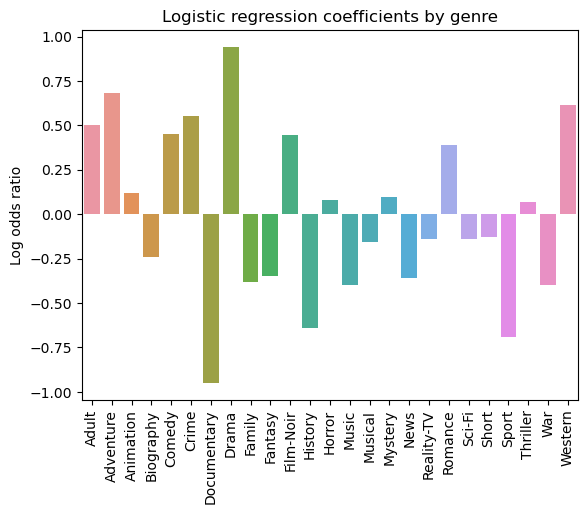

In [493]:
#barplot
sns.barplot(data=coef_genres, x=coef_genres.index, y=coef_genres[0])
plt.xticks(rotation=90)
plt.title('Logistic regression coefficients by genre')
plt.ylabel('Log odds ratio')
plt.savefig('../figures/prob_genre.png', bbox_inches='tight')
plt.show()

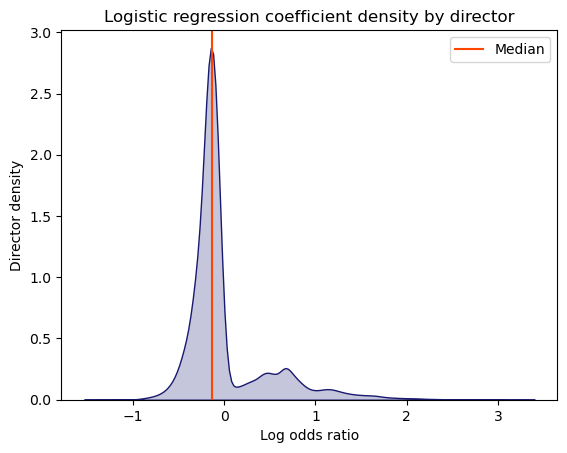

In [495]:
#kernel density plot
coef_directors = coef_directors.reset_index(drop=True)

sns.kdeplot(coef_directors[0],color="midnightblue", shade=True)
plt.axvline(coef_directors[0].median(), color="orangered", label="Median")
plt.legend()
plt.title('Logistic regression coefficient density by director')
plt.xlabel('Log odds ratio')
plt.ylabel('Director density')
plt.savefig('../figures/prob_director.png', bbox_inches='tight')
plt.show()

In [112]:
#extract propensity scores per actor
actors['propensity_score'] = [i[0] for i in list(logistic.predict_proba(X))]

In [113]:
actors.to_csv('../data/actors_us.csv')

In [153]:
actors = pd.read_csv('../data/actors_us.csv')

In [115]:
#display propensity scores
actors[['actor','propensity_score']].head()

actor  propensity_score
0     Fred_Astaire          0.920518
1    Lauren_Bacall          0.400036
2  Brigitte_Bardot          0.693610
3     John_Belushi          0.476343
4   Ingrid_Bergman          0.746998

Given the extremely large size of the dataset and the matching time needed to minimize the similarity difference between all the possible combinations (computational time goes with the number of actors squared), the matching is carried out by ordering the dataset by propensity scores, splitting it into smaller sets and performing the matching on each. The method is valid because each smaller set will have the most similar propensity scores (method suggested by Prof. Bob West).

In [148]:
#function to compute similarity (difference between propensity scores to be minimized in the matching)
def get_similarity(prop1,prop2):
    return 1-abs(prop1-prop2)

In [147]:
#splitting threshold for treatment and control groups (based on the new cut dataset)
threshold = np.percentile(actors.appearances,80)
threshold

8.0

In [146]:
len(actors)

66457

In [ ]:
#randomly remove one actor because 66457 is a prime number (what's the probability) and
#therefore we cannot split equally if we don't
actors = actors.sample(frac=0.9999849526761665)

In [ ]:
#sort dataset by propensity score
actors_prop = actors.sort_values(by=['propensity_score'],ascending=True).reset_index()

In [ ]:
#define matrix with the indexes of the multiple groups on each row
#count = np.array(actors_prop.index).reshape(169,301)
count = np.array(actors_prop.index).reshape(213,312)

In [ ]:
T = pd.DataFrame([]) #initialize auxiliary matrix

for i in range(len(count)):
    
    #define treatment and control groups
    treat = actors_prop.loc[count[i,:]][actors_prop['appearances'] > threshold]
    contr = actors_prop.loc[count[i,:]][actors_prop['appearances'] <= threshold]
    
    G = nx.Graph() #create empty undirected graph
    
    for i, j in contr.iterrows():
        for k, l in treat.iterrows():
            if j['gender'] == l['gender']: #perfect match on gender
                #Calculate the similarity 
                similarity = get_similarity(j['propensity_score'],
                                            l['propensity_score'])

                #Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(i, k, similarity)])
            
    matching = nx.max_weight_matching(G) #perform the matching

    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)] #create list with all indexes of people paired

    balanced_df = actors_prop.loc[matched] #extract only rows with paired subjects
    
    T = T.append(balanced_df) #append to auxiliary matrix

In [ ]:
#export balanced dataset
T.to_csv('../data/balanced_df.csv')

In [122]:
#import balanced dataset
balanced_df = pd.read_csv('../data/balanced_df.csv', index_col=0)
balanced_df.head()

index  Unnamed: 0            actor  grade_avg  grade_sum  appearances  \
90   21831       28387      Kelly_Royce   1.901882  13.313173            7   
72   26587       34602    Phillips_Lord   2.598496   5.196992            2   
32    1607        1639      Amy_Yasbeck   4.503093  18.012371            4   
199  60627       81178    Ariana_DeBose   4.171742  12.515225            3   
180  25818       33604  Barbara_Leonard   1.984887   7.939550            4   

    gender  year_avg  birth_year main_genre 2nd_genre           director  \
90       F    1972.0      1967.0     Comedy       NaN      Henri_Pachard   
72       M    2007.5      1902.0      Drama       NaN  William_A._Seiter   
32       F    1976.0      1962.0     Comedy     Drama         Mel_Brooks   
199      F    1928.0      1991.0      Drama  Thriller   Steven_Spielberg   
180      F    2021.0      1908.0      Drama       NaN   William_Dieterle   

           2nd_director  treatment  propensity_score  
90          Paul_Thomas          0          0.239259  
72                  NaN          0          0.234037  
32       Melanie_Mayron          0          0.203712  
199        Sam_Zalutsky          0          0.263462  
180  Claude_Autant-Lara          0          0.261439

In [149]:
print('We matched ' + str(len(balanced_df)) + ' actors')
print('We discarded ' + str(len(actors)-len(balanced_df)) + ' actors')

We matched 20688 actors
We discarded 45769 actors


The distribution is not a power law anymore. Given that the teatment group was way smaller than the control group, most of the discarded actors came from the latter.

## Analysis on balanced dataset

In this section we compare the balanced dataset with the original one, to have a sense of the matching process and to understand if the confounders have been properly tackled. Indeed, propensity score matching can result in imperfect matching.

Given the larger size of the control group, the majority of the discarded actors come from there

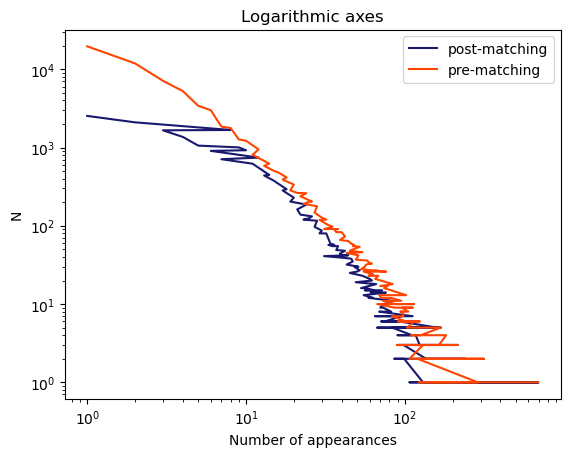

In [150]:
#group by number of appearances and sort
act_post = balanced_df.groupby('appearances')['appearances'].count().sort_values(ascending=False)
act_pre = actors.groupby('appearances')['appearances'].count().sort_values(ascending=False)

plt.loglog(act_post.index,act_post.values,label='post-matching', color='midnightblue')
plt.loglog(act_pre.index,act_pre.values,label='pre-matching', color='orangered')
plt.title('Logarithmic axes')
plt.legend()
plt.xlabel('Number of appearances')
plt.ylabel('N')
    
plt.savefig('../figures/power_law_balanced.png', bbox_inches='tight')
plt.show()

### How do the genders compare?

A linear regression implementation shows that the influence of gender on being in the treatment group has been correctly removed (non-statistically significant correlation).

In [158]:
#linear regression to show gender balance
X1 = balanced_df[{'treatment','grade_avg','gender','birth_year','year_avg','director'}]
  
import statsmodels.formula.api as smf
    
mod = smf.ols(formula='treatment ~ C(gender)',
              data=X1)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              treatment   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 0.0003733
Date:                Wed, 21 Dec 2022   Prob (F-statistic):              0.985
Time:                        16:01:19   Log-Likelihood:                -14739.
No. Observations:               20688   AIC:                         2.948e+04
Df Residuals:                   20686   BIC:                         2.950e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4188      0.006     75.

In [181]:
#divide treatment and control groups before matching
pre_t = actors[actors['treatment'] == 1]
pre_c = actors[actors['treatment'] == 0]

In [182]:
#divide treatment and control groups after matching
post_t = balanced_df[balanced_df['treatment'] == 1]
post_c = balanced_df[balanced_df['treatment'] == 0]

In [183]:
balanced_df['is_post'] = 1
actors['is_post'] = 0

In [184]:
df_tot = balanced_df.append(actors)

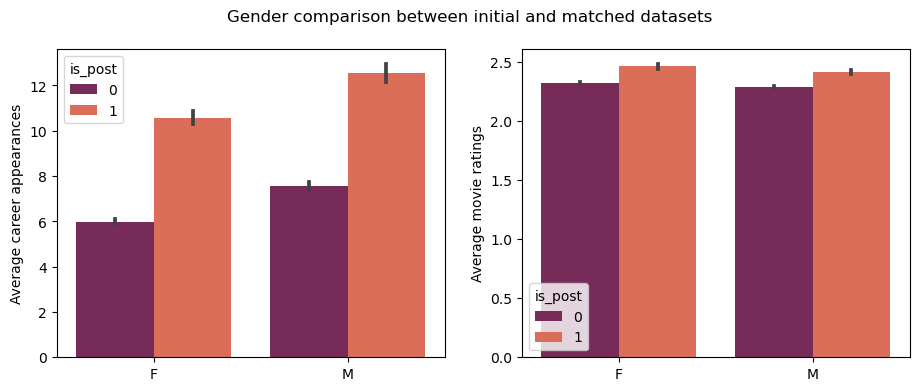

In [237]:
#bar plot with 95% confidence intervals
import seaborn as sns

#3 subplots
fig, ax = plt.subplots(1,2, figsize=(11,4))

sbplt = ax[0]
sns.barplot(ax=ax[0], x="gender", y="appearances", hue='is_post', data=df_tot, palette='rocket')
sbplt.set_ylabel('Average career appearances')
sbplt.set_xlabel('')

sbplt = ax[1]
sns.barplot(ax=ax[1], x="gender", y="grade_avg", hue='is_post', data=df_tot, palette='rocket')
sbplt.set_ylabel('Average movie ratings')
sbplt.set_xlabel('')
    
#fig.tight_layout()
plt.rcParams.update({'font.size': 10})
plt.savefig('../figures/gender2.png', bbox_inches='tight')
fig.suptitle('Gender comparison between initial and matched datasets')
plt.show()

In [238]:
#split original dataset into actors/actresses
dt1 = actors[actors['gender'] == 'M']
dt2 = actors[actors['gender'] == 'F']

#split balanced dataset into actors/actresses
male_df = balanced_df[balanced_df['gender'] == 'M']
female_df = balanced_df[balanced_df['gender'] == 'F']

In [239]:
#post-matching stats
print(stats.mannwhitneyu(dt1.appearances, dt2.appearances)) #mann-whitney u test
print(stats.mannwhitneyu(dt1.grade_avg, dt2.grade_avg)) #mann-whitney u test

MannwhitneyuResult(statistic=534502483.0, pvalue=0.00103992037166748)
MannwhitneyuResult(statistic=510829105.5, pvalue=4.7902190796082946e-11)


In [188]:
#post-matching stats
print(stats.mannwhitneyu(male_df.appearances, female_df.appearances)) #mann-whitney u test
print(stats.mannwhitneyu(male_df.grade_avg, female_df.grade_avg)) #mann-whitney u test

MannwhitneyuResult(statistic=50831142.5, pvalue=0.34569140117232866)
MannwhitneyuResult(statistic=48661036.5, pvalue=2.017959772214679e-05)


In [189]:
len(female_df)/len(balanced_df)

0.3804137664346481

In [190]:
len(dt2)/len(actors)

0.39285553064387496

### And the genres?

It is interesting to investigate trends in the genres of movies that have larger rating impact. This could show if the preferences of the audience are diversified or if they tend to stick to certain types of films.

In [192]:
#group average apperances by main actor genre
df_genre_app = df_tot[df_tot['is_post']==0].groupby('main_genre')['appearances'].mean()
df_genre_app1 = df_tot[df_tot['is_post']==1].groupby('main_genre')['appearances'].mean()

In [195]:
#std and variance pre-matching
print(df_genre_app.std())
print(df_genre_app.var())

2.464521502034228
6.073866233989047


In [196]:
#std and variance post-matching
print(df_genre_app1.std())
print(df_genre_app1.var())

1.4237416977063593
2.027040421787786


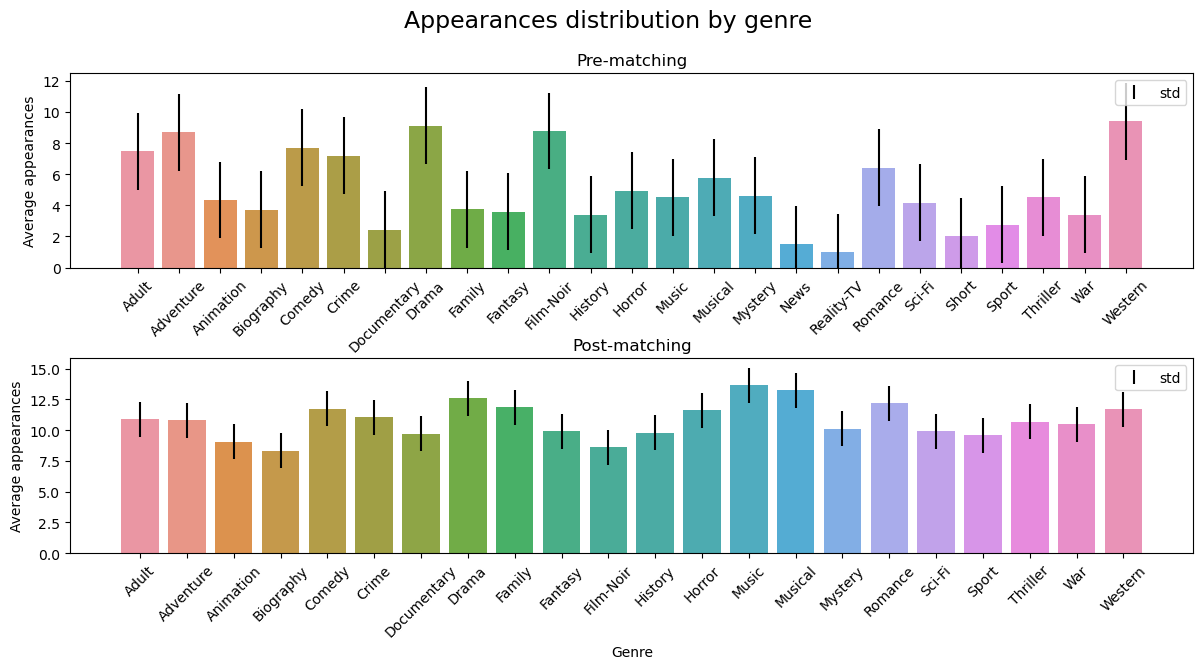

In [501]:
#nice plot that shows the balance in genres (also thanks to the reduction in std and variance
y_std = df_genre_app.std()
y_std1 = df_genre_app1.std()

# setting the dimensions of the plot
fig, ax = plt.subplots(2,1, figsize=(12, 8))

sbplt = ax[0]
sns.barplot(ax=ax[0],x=df_genre_app.index,y=df_genre_app)
sbplt.errorbar(x=df_genre_app.index, y=df_genre_app, yerr=y_std, fmt='none', color='k',label='std')
sbplt.legend()
sbplt.set_title('Pre-matching')
sbplt.set_ylabel('Average appearances')
sbplt.set_xticklabels(df_genre_app.index,rotation=45, fontsize=10)
sbplt.set_xlabel('')
sbplt.set_ylim(0,12.5)

sbplt = ax[1]
sns.barplot(ax=ax[1],x=df_genre_app1.index,y=df_genre_app1)
sbplt.errorbar(x=df_genre_app1.index, y=df_genre_app1, yerr=y_std1, fmt='none', color='k',label='std')
sbplt.legend()
sbplt.set_title('Post-matching')
sbplt.set_xlabel('Genre')
sbplt.set_ylabel('Average appearances')
sbplt.set_xticklabels(df_genre_app1.index,rotation=45, fontsize=10)

fig.tight_layout()
fig.suptitle('Appearances distribution by genre', fontsize=17)
fig.subplots_adjust(top=.9, bottom=0.3)
plt.savefig('../figures/genres1.png', bbox_inches='tight')
plt.show()

To clarify, Animation genre means actor giving their voice to characters, while Music genre refers to movies about music or musicians (e.g., The Bohemian Rapsody).

In [198]:
#group genres for pie chart
genre_df = balanced_df.groupby('main_genre',as_index=True)['main_genre'].count()
genre_df = genre_df.apply(lambda x: x/genre_df.sum()*100)

In [199]:
genre_df

main_genre
Adult           0.033836
Adventure       8.792537
Animation       1.363109
Biography       0.290023
Comedy          7.153906
Crime           8.565352
Documentary     0.212684
Drama          41.763341
Family          1.662800
Fantasy         1.657966
Film-Noir       0.164346
History         0.797564
Horror          4.413186
Music           1.082753
Musical         1.556458
Mystery         2.721384
Romance         9.947796
Sci-Fi          1.672467
Sport           0.246520
Thriller        4.176334
War             0.763728
Western         0.961910
Name: main_genre, dtype: float64

### And the directors?

Let's check the distribution of actors' main directors in the balanced dataset.

In [201]:
df_dir_post = balanced_df.groupby('director')['appearances'].mean()
df_dir_pre = actors.groupby('director')['appearances'].mean()

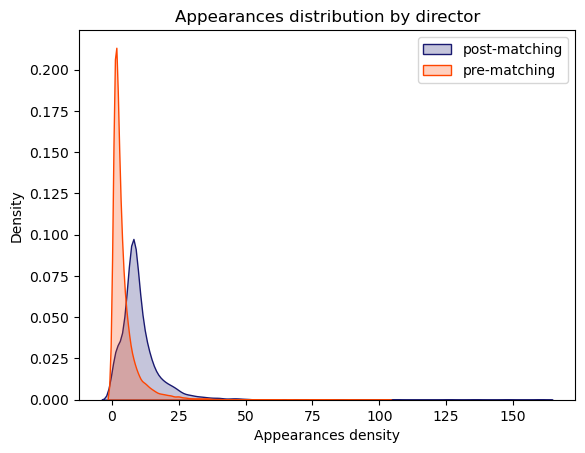

In [202]:
#kernel density plot
coef_directors = df_dir_post.reset_index(drop=True)
coef_directors1 = df_dir_pre.reset_index(drop=True)

sns.kdeplot(coef_directors,label='post-matching', shade=True, color='midnightblue')
sns.kdeplot(coef_directors1,label='pre-matching', shade=True, color='orangered')
plt.legend()
#plt.yscale('log')
#plt.xscale('log')
plt.title('Appearances distribution by director')
plt.xlabel('Career appearances')
plt.xlabel('Appearances density')
plt.savefig('../figures/prob_director2.png', bbox_inches='tight')
plt.show()

In [245]:
print(df_dir_pre.var())
print(df_dir_post.var())

38.67188542106403
83.84689554694022


## Impact of treatment group on average movie ratings

To evaluate which regression model to be used to assess the influence of coming from the treatment group on the ratings, cross-validation is used.

To quantify the effect of coming from the treatment group on the average movie ratings, we implement a linear regression. After the matching, the positive influence on ratings of being from treatment group decreases.

**This is indication that the overall effect of the studied confounders increases the impact that being from the treatment causes to the ratings.** From another perspective, these confounders (gender, genres, directors) help actors in the treatment group (successful actors) impact movie ratings more.

Let's quantify with the regression.

In [210]:
#regression pre-matching
import statsmodels.formula.api as smf
    
mod_pre = smf.ols(formula='grade_avg ~ treatment',data=actors)              

res_pre = mod_pre.fit()
print(res_pre.summary())

                            OLS Regression Results                            
Dep. Variable:              grade_avg   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1295.
Date:                Wed, 21 Dec 2022   Prob (F-statistic):          8.35e-281
Time:                        16:14:25   Log-Likelihood:                -87306.
No. Observations:               66457   AIC:                         1.746e+05
Df Residuals:                   66455   BIC:                         1.746e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2409      0.004    578.575      0.0

In [211]:
#regression post-matching
mod_post = smf.ols(formula='grade_avg ~ treatment',data=balanced_df)              

res_post = mod_post.fit()
print(res_post.summary())

                            OLS Regression Results                            
Dep. Variable:              grade_avg   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     45.79
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           1.35e-11
Time:                        16:14:38   Log-Likelihood:                -27464.
No. Observations:               20688   AIC:                         5.493e+04
Df Residuals:                   20686   BIC:                         5.495e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4010      0.008    288.447      0.0

In [224]:
#coefficients of the ratings predictor
C_pre = res_pre.params.values[1]
C_post = res_post.params.values[1]

In [230]:
#decrease in influence of being from the treatment group on the average ratings
print(str(C_post/C_pre*100) + '%')

27.021272958945097%


From the KDE plots of the distributions of ratings in treatment and control groups before and after the matching, it is visible how the benefit that coming from the treatment brings to the movie ratings decreases. Indeed, the two curves are almost overlapping in the post-matching case-

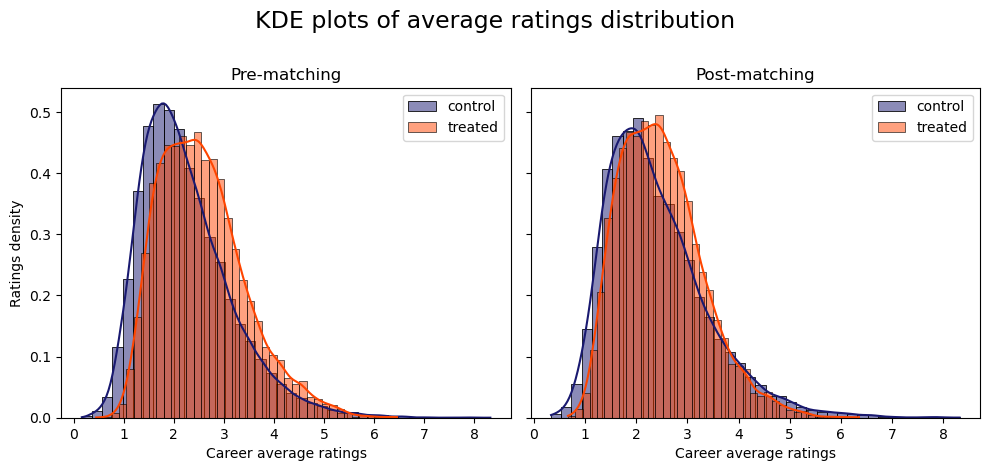

In [205]:
fig, ax = plt.subplots(1,2, figsize=(10, 6), sharey=True)

sbplt = ax[0]
ax[0] = sns.histplot(pre_c.grade_avg, kde=True, stat='density', ax=ax[0], color='midnightblue', label='control', bins=40)
ax[0] = sns.histplot(pre_t.grade_avg, kde=True, stat='density', ax=ax[0], color='orangered', label='treated', bins=40)
sbplt.legend()
sbplt.set_title('Pre-matching')
sbplt.set_xlabel('Career average ratings')
sbplt.set_ylabel('Ratings density')

sbplt = ax[1]
ax[1] = sns.histplot(post_c.grade_avg, kde=True, stat='density', ax=ax[1], color='midnightblue', label='control', bins=40)
ax[1] = sns.histplot(post_t.grade_avg, kde=True, stat='density', ax=ax[1], color='orangered', label='treated', bins=40)
sbplt.legend()
sbplt.set_title('Post-matching')
sbplt.set_xlabel('Career average ratings')

fig.tight_layout()
fig.suptitle('KDE plots of average ratings distribution', fontsize=17)
fig.subplots_adjust(top=.85, bottom=0.3)
plt.savefig('../figures/kde_ratings.png', bbox_inches='tight')
plt.show()

In [206]:
#stats
print(np.median(pre_c.grade_avg))
print(np.median(pre_t.grade_avg))
print(np.median(post_c.grade_avg))
print(np.median(post_t.grade_avg))

2.0795071205917446
2.462029196108127
2.21761977362425
2.4061338144080375


# Piggybacking actors identification

To quantify the amount of 'piggybacking' actors in the dataset, we come up with a strategy. we first focus on the control group, the more prone to piggyback, gives that most of them are ones-hit wonders and in thei low number of appearances they could have starred with famous actors who brought up their average career movie ratings.

## Control group

At first, **we focus on the actors from the control group (low appearances)**, and we try to understand how many of these actors have an impactful rating because they co-starred with other successful actors (high appearances). To do this, we compute the number of movies where each actor from the control group starred with at least one actor from the treatment group, and we define a **piggybacking percentage (PP)**.

$PP = \frac{movies\ with\ actor\ from\ treatment\ group}{movies\ without\ actors\ from\ the\ treatment\ group} \cdot 100$

This will give a sense of the fraction of movies where actors from the control group 'piggybacked' on more successful actors from the treatment group. As a remainder, this is based on the assumption that successful actors are actors who manage to join the rich-get-richer circle and keep starring.

In [8]:
#actors_bal = pd.read_csv('../data/balanced_df.csv').iloc[:, 3:]
#info = pd.read_csv('../data/movies_us.csv').iloc[:, 1:][['title', 'averageRating_adj', 'actor']]

In [13]:
#extract control group from balanced dataset
control = balanced_df.query('treatment == 0').reset_index(drop = True)

In [14]:
len(control)

12022

In [18]:
#extract cast list per movie
cast_list_movie = pd.DataFrame(us.groupby('title').apply(lambda m: m['actor'].values.tolist())).reset_index()
cast_list_movie.columns = ['title', 'cast']
print('getting cast per movie DONE')

movies_per_actor = pd.DataFrame(us.groupby('actor').apply(lambda a: 
                    pd.Series(a['title']).unique().tolist()), columns = ['title'])
print('list of movies per actor DONE')

piggy_percentages = []
for idx, a in enumerate(control['actor']):
    
    if (idx % 2000 == 0): print('calculating actor edge list at ' + str(round(100*idx/len(control), 1)) + '%')
                              
    movies = cast_list_movie[cast_list_movie['title'].isin(movies_per_actor.loc[a, 'title'])]
    
    pigs = 0
    for jdx, m in movies.iterrows():
            
        stars = balanced_df[balanced_df['actor'].isin(m['cast'])].query('treatment == 1')
        if(idx == 1):
            print('\n', 'EXAMPLE:')
            print('list of actors :', m['cast']) 
            print('are they stars? :', stars)
        if (not(stars.empty)):
            pigs += 1
        
    
    #percentage of piggybacking per total movies done by actor
    piggy_percentages.append(pigs/len(movies))
    
print('piggy_percentage done')

getting cast per movie DONE
list of movies per actor DONE
calculating actor edge list at 0.0%

 EXAMPLE:
list of actors : ['Bette_Davis', 'Bette_Davis', 'Frank_Albertson', 'Frank_Albertson', 'Jeon_Do-yeon', 'Phillips_Lord', 'Phillips_Lord', 'Effie_Palmer', 'Effie_Palmer', 'Go_Soo', 'Kathryn_Bernardo', 'Julia_Montes', 'Sam_Concepcion', 'Claudette_Lalí', 'Yeom_Hye-ran']
are they stars? :                  actor  grade_avg   grade_sum  appearances gender    year_avg  \
968        Bette_Davis   3.647896  525.296982          144      F  2018.00000   
5034   Frank_Albertson   1.900971  125.464070           66      M  2012.00000   
5245  Kathryn_Bernardo   2.914092   29.140924           10      F  2004.53125   
9866      Jeon_Do-yeon   3.400304   61.205464           18      F  2017.00000   

      birth_year main_genre 2nd_genre             director      2nd_director  \
968       1908.0      Drama   Romance      Alfred_E._Green  William_Dieterle   
5034      1909.0      Drama   Romance       J

In [84]:
#assign piggybacking percentages to each actor in the dataset
control['pp'] = piggy_percentages

It is interesting to see that the percentage of control actors who starred at least once with treatment actors is **88%**. Therefore, most of the less successful actors raise their rating impact because of others actors' success. 

In [85]:
#fraction of control actors who starred at least once with a treatment actor
print(len(control.query('pp > 0'))/len(control))

0.8828813841290967


While the percentage of actors who ONLY starred with treatment actors reduces to **49%**.

In [109]:
#fraction of control actors who always starred a treatment actor
print(len(control.query('pp == 1'))/len(control))

0.4861919813674929


To check if the 'piggybacking actors' actually have a statistically significant difference in career rating with the 'non-piggybacking' ones, we perform a Mann-Whitney U test on the two distributions.

The results show that the difference is indeed **significant**.

In [122]:
stats.mannwhitneyu(control.query('pp > 0').grade_avg, 
                control.query('pp == 0').grade_avg) #mann whitney u test

MannwhitneyuResult(statistic=8115381.0, pvalue=1.47386703051115e-07)

## Treatment group